# <span style="color:#0066CC">PREDICTING BANK PRODUCT SUBSCRIPTION</span>

Authors:

- Miguel Ramos Cabañas 100473854

- Miguel Rodríguez Losada 100568756

##  <span style="color:#0066CC">Libraries Import</span>

Before starting the analysis, we first import all the libraries we’ll need throughout the assignment.
These include basic tools for working with data (like pandas and numpy), plotting (matplotlib), and building machine-learning models (scikit-learn).
Having all the imports together at the beginning keeps the notebook organized and makes it easier to see which tools we are using.

In [4]:
import time
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from statsmodels.stats.proportion import proportion_confint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, brier_score_loss, log_loss
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb 
from lightgbm import early_stopping
from scipy.stats import randint, uniform
from sklearn.base import clone
from joblib import dump
import joblib
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import shap
import lime
import lime.lime_tabular
from sklearn.inspection import permutation_importance
from IPython.display import display, HTML
import warnings
import os
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", module="lightgbm")

**Note :** All intermediate outputs have been deliberately suppressed to improve readability and ensure a cleaner presentation of the results.

##  <span style="color:#0066CC"> Data Import</span>

We use the last 2 digits from the NIA of the first author. As a consequence, we select the data folder **bank_54**.

For convenience and ease of manipulation, the data are loaded into a pandas DataFrame.


In [5]:
data = pd.read_pickle("P1_assignment_dataset_bank_ALL/bank_54.pkl")

print(data.head())

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  


##  <span style="color:#0066CC"> Simplified EDA</span>

Before exploring the data, it is useful to understand what each variable represents.
The table below summarizes all the columns in the dataset, including client information, campaign details, and the target variable deposit.

| Variable | Short Description |
| :--- | :--- |
| **age** | age in years |
| **job** | type of job |
| **marital** | marital status |
| **education** | education level |
| **default** | has credit in default? |
| **balance** | average yearly balance |
| **housing** | has a housing loan? |
| **loan** | has a personal loan? |
| **contact** | contact communication type |
| **day_of_week** | last contact day |
| **month** | last contact month |
| **duration** | last contact duration, in seconds |
| **campaign** | number of contacts performed during this campaign and for this client |
| **pdays** | number of days that passed by after the client was last contacted from a previous campaign. The value is -1 if no/unknown contact was produced. |
| **previous** | number of contacts performed before this campaign and for this client |
| **poutcome** | outcome of the previous marketing campaign |
| **deposit** | has the client subscribed a term deposit? **TARGET VARIABLE** |

To begin the exploratory analysis, we first determine the size of the dataset by identifying the total number of instances (rows) and features (columns).

In [6]:
print("The number of instances (rows) in the dataset is", len(data), "and the number of features (columns) is", len(data.columns))

The number of instances (rows) in the dataset is 11000 and the number of features (columns) is 17


Also, it is important to understand the type of each variable in the dataset.  
This helps us decide how to handle them later: for example, numerical features may require scaling, while categorical features need encoding.  

In the following step, we separate the variables into two groups:
- **Numerical variables** (integers or floats) 
- **Categorical variables** (strings or objects)

In [7]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object','category']).columns.tolist()

print("Numerical variables:", numerical_cols)
print("Categorical variables:", categorical_cols)

Numerical variables: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical variables: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


In the following step, we compute the number of unique values for each categorical feature to detect potential high-cardinality columns.

In [8]:
unique_counts = {col: data[col].nunique() for col in categorical_cols}

print("Number of unique categories per categorical variable:")
for col, count in unique_counts.items():
    print(f"{col}: {count}")

Number of unique categories per categorical variable:
job: 12
marital: 3
education: 4
default: 2
housing: 2
loan: 2
contact: 3
month: 12
poutcome: 4
deposit: 2


We next examine the presence of missing values and identify any features that may need special treatment.  
Specifically, we check:
- whether any variables contain missing entries,
- whether any columns are constant (i.e., have only one unique value), and
- whether any column behaves like an identifier, containing a different value for every row.


In [9]:
missing_values = data.isna().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
age            0
job            0
marital      538
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
deposit        0
dtype: int64


In addition to checking for missing values, it is important to compute the occurrences of "unknown" because several categorical variables use this label to represent missing information, which is not captured by standard NaN checks and could otherwise bias the preprocessing and model training stages.

In [10]:
unknown_counts = (data[categorical_cols] == "unknown").sum()

print("Number of 'unknown' entries per categorical variable:")
print(unknown_counts)

Number of 'unknown' entries per categorical variable:
job            68
marital         0
education     494
default         0
housing         0
loan            0
contact      2309
month           0
poutcome     8205
deposit         0
dtype: int64


In [11]:
constant_cols = [col for col in data.columns if data[col].nunique() == 1]
print("\nConstant columns:")
print(constant_cols)


Constant columns:
[]


In [12]:
id_like_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("\nID-like columns:")
print(id_like_cols)


ID-like columns:
[]


During these steps of the simplified exploratory analysis, we observed that the variable **`marital`** contains 538 missing entries which represents less than 5% of the total observations. Since this feature is categorical and represents the marital status of each client, we can address the missingness in two different perspectives:
* by applying a *SimpleImputer* with `strategy = 'most_frequent'`, which replaces missing values with the most common category observed in the data.
* by applying a *SimpleImputer* with `strategy = 'constant'`, which creates a new variable with the unknown marital status.

This imputation is performed **after** the train/test split (specifically, within the pipeline fitted on the training data). This choice is justified because:

* It prevents **data leakage**: The mode (most frequent value) is calculated exclusively from the **training set**.
* This learnt value is then applied to fill missing entries in the **test set**. This simulates a real-world scenario where the model must handle missing data in new, unseen clients based solely on what it learned during training.

In addition to standard missing values, several categorical variables use the label “unknown” to represent missing or unspecified information.
These values are not detected by the usual NaN checks and therefore require special attention.
Notably, variables such as **`education`**, **`contact`**, and especially **`poutcome`** contain a large number of "unknown" entries, which may influence the preprocessing choices (e.g., treating "unknown" as its own category or performing imputation).

We also checked for constant columns, and none were found.
This is positive, as it indicates that every feature contributes some variability to the dataset.

Finally, there are no ID-like columns, meaning the dataset does not include fields that uniquely identify each row.
This confirms that all variables are potentially useful for modelling and that no column needs to be removed for behaving like an identifier.

After this initial inspection of the dataset, we can verify that the task corresponds to a **binary classification problem**, where the **target variable** **`deposit`** takes two possible values: yes or no.

The objective is to predict whether a client has subscribed to a term deposit based on the available features.

To verify whether the classification problem is imbalanced, we examine the class proportions of the target variable `deposit`. This will be a key point to determine the strategy for the outer and inner evaluation.


In [13]:
data['deposit'].value_counts(normalize=True)


deposit
no     0.525455
yes    0.474545
Name: proportion, dtype: float64

The target variable shows a proportion of approximately 52.5% for "no" and 47.5% for "yes".  
This distribution is relatively balanced, meaning we do not need any special imbalanced-learning techniques.  

The variable **`pdays`** indicates the number of days since the client was last contacted in a previous campaign.  
A value of **–1** means the client was never contacted.  

In [14]:
print(data['pdays'].describe())

count    11000.000000
mean        51.308636
std        108.782842
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         20.250000
max        854.000000
Name: pdays, dtype: float64



Most values are –1, meaning the variable is highly skewed and not suitable as a standard numerical feature.  

A good strategy to simplify its interpretation, would be create a new categorical variable:

- False → client was never contacted
- True → client was previously contacted  

This captures the relevant information without misinterpreting –1 as a real day count.

In [15]:
# Binary transformation of pdays
data['pdays_contacted'] = (data['pdays'] != -1).astype('category')

# Quick check
data['pdays_contacted'].value_counts()

pdays_contacted
False    8203
True     2797
Name: count, dtype: int64

After creating the categorical variable **`pdays_contacted`**, we also need to prepare the original **`pdays`** column for use as a numerical feature. Since the value `-1` indicates that the client has never been contacted, it is not a valid numeric distance for modeling purposes.  

To ensure that **`pdays`** behaves as a consistent numerical variable, we replace `-1` with `0`, keeping the same variable name. This transformation preserves all meaningful positive day counts while preventing the presence of an artificial negative value that could distort scaling or distance-based algorithms.

In [16]:
data["pdays"] = data["pdays"].replace(-1, 0)
print(data['pdays'].describe())

count    11000.000000
mean        52.054364
std        108.424506
min          0.000000
25%          0.000000
50%          0.000000
75%         20.250000
max        854.000000
Name: pdays, dtype: float64


Before feeding the data into the main Scikit-Learn `Pipeline`, we explicitly handle the transformation of the `pdays` variable (creating the `pdays_contacted` flag and modifying the raw `pdays` values).

**Justification for this approach:**

1.  **No Risk of Data Leakage (Statelessness):**
    The transformation `(pdays != -1)` is a **row-independent** operation. The value for a specific client depends only on their own data, not on the distribution or statistics of the rest of the dataset (unlike scaling or mean imputation). Therefore, applying it globally before the pipeline does not compromise the integrity of the validation.

2.  **Computational Efficiency:**
    During intensive hyperparameter optimization , the pipeline is fitted thousands of times. By pre-calculating these static features once outside the training loop, we avoid redundant recalculations for every single fold and parameter combination, reducing the total execution time.

3.  **Readability & Transparency:**
    Implementing this logic directly in Pandas allows for immediate verification of the data quality (like checking `value_counts` or distributions) before model ingestion. It avoids the unnecessary complexity of wrapping simple one-line logic into custom Scikit-Learn transformers.

In [17]:
# Just checking all the variables in our data
print(data.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit', 'pdays_contacted']


**Note:**  The variables **`day_of_week`** and **`month`** could be preprocessed in several ways, such as encoding them jointly, applying cyclical transformations, or deriving new temporal features that capture seasonal patterns. Each of these approaches has potential advantages and disadvantages.  In this exploratory stage, we deliberately keep both variables in their original categorical form. This decision preserves potentially meaningful behavioural signals, for example, differences in subscription patterns between clients contacted at the beginning versus the end of a month.  


##  <span style="color:#0066CC"> Definition of the outer and inner evaluation</span>

###  <span style="color:#0066CC"> Definition of the outer evaluation</span>

Before training any predictive model, we first need to define the evaluation strategy that will be used to estimate its future performance. According to the assignment guidelines, the chosen evaluation method must be **Houldout**, therefore we must decide what proportion of the data will be allocated to the training and test partitions.

To make this decision in a principled way, we analyze several possible test sizes and examine how they affect both the estimated accuracy and the uncertainty of that estimate, expressed through 95% Clopper–Pearson confidence intervals. This approach follows the methodology discussed in Topic 3: Model Evaluation, where the width of the confidence interval is used as a measure of the reliability of the performance estimate.

Therefore, we evaluate multiple test sizes (5%, 10%, 15%, 20%, 25%, 30%), compute the corresponding accuracy and confidence intervals using a simple decision tree as a proxy model, summarize the results in a table, and finally visualize how both uncertainty and accuracy vary with the test size.


In [18]:
# 1. ANALYSIS FUNCTION 
def analyze_test_accuracy(data, target_col, test_sizes=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    """
    We analyze the effect of different test sizes on accuracy estimates using a decision tree.
    We return a DataFrame including estimated accuracy, Clopper-Pearson confidence intervals, and their widths.
    Note: This methology was extracted from the notion of Binomial/Beta distribution in Topic 3 for selecting optimal test size.
    """
    
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]


    # Identify categorical columns and apply OneHotEncoder
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

    # Transform features
    X_array = preprocessor.fit_transform(X)

    # Attempt to retrieve feature names
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        feature_names = [f"feat_{i}" for i in range(X_array.shape[1])]

    # Create DataFrame with transformed features
    X = pd.DataFrame(X_array, columns=feature_names)

    # For Each Test Size: Train/Test Split, Fit Model, Compute Accuracy and CI
    results = []
    for test_size in test_sizes:
        
        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=100473854
        )

        # Fit a decision tree as a proxy model
        clf = DecisionTreeClassifier(random_state=100473854, max_depth=5)
        clf.fit(X_train, y_train)

        # Compute accuracy
        y_pred = clf.predict(X_test)
        n_test = len(y_test)
        correct_predictions = np.sum(y_pred == y_test)
        accuracy = correct_predictions / n_test

        # Compute Clopper-Pearson (Beta) confidence interval
        ci_low, ci_high = proportion_confint(correct_predictions, n_test, alpha=0.05, method='beta')
        width = ci_high - ci_low

        # We store exact numerical values to ensure plotting accuracy
        results.append({
            'Test Size %': int(test_size*100),
            'N Test': n_test,
            'N Train': len(y_train),
            'Accuracy Est.': accuracy,
            'CI Low': ci_low,
            'CI High': ci_high,
            'CI Width': width
        })

    return pd.DataFrame(results)


In [19]:
# 2. PLOTTING FUNCTION
def plot_results(df, optimal_pct=15):
    """
    We visualize the accuracy estimates and confidence intervals obtained for different test sizes.
    The first plot shows uncertainty vs. test size; the second shows error bars for estimated accuracy.
    """

    # Prepare the figures layout
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # PLOT 1: Uncertainty Curve: x-axis = test size (%), y-axis = CI width
    sizes = df['Test Size %']
    widths = df['CI Width']
    ax1.plot(sizes, widths, marker='o', linestyle='-', color='gray', label='Interval Width')

    ## Highlight the optimal test size
    row_opt = df[df['Test Size %'] == optimal_pct]
    if not row_opt.empty:
        val_width = row_opt['CI Width'].values[0]
        ax1.scatter(optimal_pct, val_width, color='red', s=150, zorder=5, label=f'Selection ({optimal_pct}%)')
        ax1.axvline(x=optimal_pct, color='red', linestyle='--', alpha=0.5)
        ax1.annotate(f'Width: {val_width:.4f}',
                     xy=(optimal_pct, val_width), xytext=(optimal_pct+2, val_width+0.01),
                     arrowprops=dict(facecolor='black', shrink=0.05))

    ## Labels and legend
    ax1.set_title('Uncertainty vs. Test Size\n(Smaller Width is Better)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Test Size (%)')
    ax1.set_ylabel('Interval Width')
    ax1.legend()

    # PLOT 2: Error Bars for Accuracy
    y_err_low = df['Accuracy Est.'] - df['CI Low']
    y_err_high = df['CI High'] - df['Accuracy Est.']
    error_bars = [y_err_low, y_err_high]
    colors = ['red' if s == optimal_pct else 'skyblue' for s in sizes]

    ax2.errorbar(sizes, df['Accuracy Est.'], yerr=error_bars, fmt='none', ecolor='gray', elinewidth=2, capsize=5)
    ax2.scatter(sizes, df['Accuracy Est.'], s=100, c=colors, zorder=3)

    ## Title and labels
    ax2.set_title('Statistical Accuracy (Real Confidence Intervals)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Test Size (%)')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


Results Table:
 Test Size %  N Test  N Train  Accuracy Est.      CI 95% Text  CI Width
           5     550    10450       0.796364 [0.7602, 0.8293]  0.069014
          10    1100     9900       0.792727 [0.7676, 0.8163]  0.048777
          15    1650     9350       0.800000 [0.7799, 0.8191]  0.039186
          20    2200     8800       0.807727 [0.7906, 0.8240]  0.033377
          25    2750     8250       0.817455 [0.8025, 0.8317]  0.029231
          30    3300     7700       0.814545 [0.8009, 0.8277]  0.026818

Generating plots...


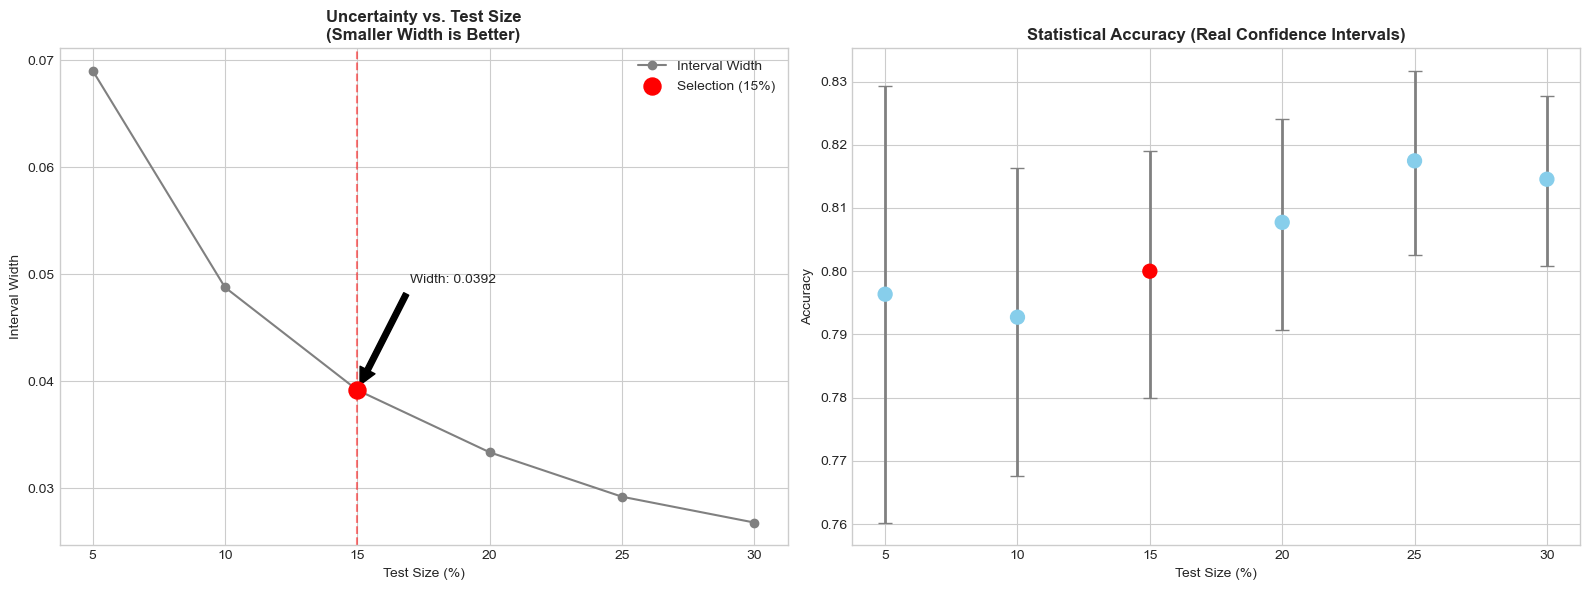

In [20]:
# 3. MAIN EXECUTION
try:
    # Run analysis function
    df_res = analyze_test_accuracy(data, "deposit")  

    # Print results table
    print("Results Table:")
    print_df = df_res.copy()
    print_df['CI 95% Text'] = print_df.apply(lambda x: f"[{x['CI Low']:.4f}, {x['CI High']:.4f}]", axis=1)
    cols_show = ['Test Size %', 'N Test', 'N Train', 'Accuracy Est.', 'CI 95% Text', 'CI Width']
    print(print_df[cols_show].to_string(index=False))

    # Generate plots
    print("\nGenerating plots...")
    plot_results(df_res, optimal_pct=15)

except NameError:
    print("Error: Please ensure the variable 'data' is loaded before running.")
except Exception as e:
    print(f"An error occurred: {e}")

In the left plot, we evaluate the width of the 95% Clopper–Pearson confidence interval for several test sizes. A smaller interval width indicates a more precise estimate of the model’s accuracy. We observe a rapid decrease in uncertainty when increasing the test size from 5% to 15%, after which the reduction becomes more gradual. At a test size of **15%**, the interval width reaches approximately **0.039**, which represents an effective balance between precision and the amount of data preserved for training.

The right plot shows the estimated accuracy for each test size, along with its corresponding confidence intervals. The accuracy remains relatively stable across all configurations, meaning that accuracy alone does not strongly favor one test size over another. However, the 15% test split provides a good compromise, offering a reliable estimate while keeping 85% of the data available for model training.

Based on this analysis, we select a **15% test size** as the evaluation strategy for the assignment.

Based on the previous analysis, we now split the dataset using the selected proportions: 85% for training and 15% for testing.

In [21]:
# Final Train/Test Split with Optimal Test Size

X = data.drop(columns='deposit') 
y = data['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15,  
    random_state=100473854, 
    stratify=y       
)

print("Size X_train:", X_train.shape)
print("Size X_test:", X_test.shape)

Size X_train: (9350, 17)
Size X_test: (1650, 17)


###  <span style="color:#0066CC"> Definition of the inner evaluation</span>

Once the **outer evaluation** has been fixed (Holdout with an 85%/15% split), the next step is to define the **inner evaluation** strategy. The inner evaluation is required for:
- performing **hyper-parameter optimisation (HPO)** 
- comparing model alternatives as part of the **CASH problem** (Combined Algorithm Selection and Hyper-parameter optimisation).

The inner evaluation must provide **reliable performance estimates** while keeping the **computational cost manageable**. 
For this reason, we explore different configurations of **Stratified K-fold Cross-Validation**, varying the number of folds from $K = 3$ to $K = 10$.

For each value of $K$, we evaluate the following criteria:

- **Mean validation accuracy** (higher is better),
- **Standard deviation of accuracy across folds** (lower is better, indicating more stable estimates),
- **Execution time** (lower is better).

To select the most appropriate cross-validation scheme, we combine these three criteria into a single score that represents the trade-off between predictive performance, stability, and computational efficiency. This score is constructed so that:

- we **reward high mean accuracy**, and  
- we **penalise high variability and high computation time**.

We then compute this score for every $K \in \{3, 4, \dots, 10\}$, visualise the resulting curve, and select the configuration that minimises the score. Note that the curve is displayed for all tested values of $K$, as it helps us understand how the trade-off evolves when increasing the number of folds.

In [22]:
# We identify numerical and categorical columns in the training set
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# We define a simple baseline pipeline (preprocess + default Decision Tree)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

baseline_tree = DecisionTreeClassifier(random_state=100473854)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', baseline_tree)
])

# We evaluate different values of K in Stratified K-fold CV
K_values = list(range(3, 11))  # 3, 4, ..., 10
cv_results = []

print("\nEvaluating inner CV configurations (DecisionTree + StratifiedKFold)...\n")

for K in K_values:
    cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=100473854)

    # We measure execution time to capture the computational cost of each K
    start_time = time.perf_counter()

    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='accuracy',
        n_jobs=1  # we keep 1 for fair timing comparisons (same hardware load across runs)
    )

    elapsed = time.perf_counter() - start_time

    # We store the mean accuracy and its standard deviation across folds
    cv_results.append({
        'K folds': K,
        'Mean Accuracy': float(np.mean(scores)),
        'Std Accuracy': float(np.std(scores)),
        'Time (s)': float(elapsed)
    })


Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']

Evaluating inner CV configurations (DecisionTree + StratifiedKFold)...



In [23]:
cv_df = pd.DataFrame(cv_results)

print("\nInner evaluation results (Decision Tree + StratifiedKFold CV):")
print(cv_df.to_string(index=False))


# We normalise the three metrics to [0, 1] so they can be combined into a single score
#    - Higher accuracy is better, so we use (1 - Acc_norm) as a penalty term.
#    - Lower time is better, so Time_norm is a penalty term.
#    - Lower std is better, so Std_norm is a penalty term.
scaler = MinMaxScaler()
cv_df[['Acc_norm', 'Time_norm', 'Std_norm']] = scaler.fit_transform(
    cv_df[['Mean Accuracy', 'Time (s)', 'Std Accuracy']]
)

# We define a trade-off score (to be minimised)
# We reward accuracy and penalise both time and variability.
w_acc = 1.0
w_time = 2.0
w_std = 1.0

cv_df['TradeoffScore'] = (
    w_acc * (1 - cv_df['Acc_norm']) +
    w_time * cv_df['Time_norm'] +
    w_std * cv_df['Std_norm']
)

# We select the K with the minimum trade-off score (no filtering)
best_idx = cv_df['TradeoffScore'].idxmin()
K_best = int(cv_df.loc[best_idx, 'K folds'])

print("\nSelected K (minimum TradeoffScore):", K_best)
print("Selected row:")
print(cv_df.loc[[best_idx], ['K folds', 'Mean Accuracy', 'Std Accuracy', 'Time (s)', 'TradeoffScore']].to_string(index=False))



Inner evaluation results (Decision Tree + StratifiedKFold CV):
 K folds  Mean Accuracy  Std Accuracy  Time (s)
       3       0.791872      0.004210  1.184237
       4       0.790696      0.002281  1.680635
       5       0.785134      0.007782  2.045192
       6       0.787381      0.006628  2.277427
       7       0.788769      0.010905  2.949066
       8       0.792083      0.011734  3.063125
       9       0.799786      0.009978  4.148828
      10       0.794118      0.008913  6.477708

Selected K (minimum TradeoffScore): 3
Selected row:
 K folds  Mean Accuracy  Std Accuracy  Time (s)  TradeoffScore
       3       0.791872       0.00421  1.184237       0.744255


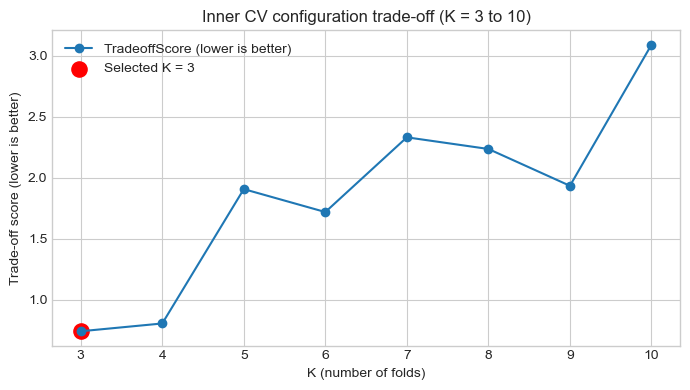

In [24]:
# We plot the trade-off curve for ALL tested K values (3 to 10)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(
    cv_df['K folds'],
    cv_df['TradeoffScore'],
    marker='o',
    linestyle='-',
    label='TradeoffScore (lower is better)'
)

ax.scatter(
    K_best,
    cv_df.loc[best_idx, 'TradeoffScore'],
    color='red',
    s=120,
    label=f'Selected K = {K_best}'
)

ax.set_xlabel('K (number of folds)')
ax.set_ylabel('Trade-off score (lower is better)')
ax.set_title('Inner CV configuration trade-off (K = 3 to 10)')
ax.legend()

plt.tight_layout()
plt.show()


The inner evaluation results indicate that the mean cross-validation accuracy is relatively stable for all values of  $K \in \{3, \dots, 10\}$, with values ranging approximately from 0.784 to 0.799. 

As $K$ increases, however, both the computational time and the standard deviation of the accuracy across folds tend to increase, leading to higher variability and cost without clear gains in predictive performance.

To objectively select the most appropriate number of folds, we defined a composite trade-off criterion that simultaneously accounts for accuracy, stability, and computational efficiency. After normalising each metric to the $[0, 1]$ range, the following score was minimised:

$$
\mathrm{TradeoffScore}(K)
= \bigl(1 - \mathrm{Acc}_{\mathrm{norm}}(K)\bigr)
+ \lambda_{\mathrm{time}} \cdot \mathrm{Time}_{\mathrm{norm}}(K)
+ \lambda_{\mathrm{std}} \cdot \mathrm{Std}_{\mathrm{norm}}(K),
$$

with $\lambda_{\mathrm{time}} = 2$ penalising computational cost and  $\lambda_{\mathrm{std}} = 1$ penalising variability across folds.

The resulting trade-off curve shows a clear minimum at $K = 3$. This configuration achieves a competitive mean accuracy while maintaining low variance across folds and significantly lower execution time compared to larger values of $K$.

Based on this quantitative analysis, **$K = 3$** is selected as the inner cross-validation strategy for hyper-parameter optimization and model comparison in the subsequent stages of the assignment.

In [25]:
optimal_cv = 3
inner = StratifiedKFold(n_splits=optimal_cv, shuffle=True, random_state=100473854)

##  <span style="color:#0066CC"> Basic Methods: KNN and Trees</span>

###  <span style="color:#0066CC"> Baseline Models: Training, Evaluation and Comparison</span>

First, we proceed to train a K-Nearest Neighbours (KNN) classifier on the training dataset, using the default hyperparameters provided by scikit-learn.

In [23]:
# Identify numerical and categorical columns on the training set
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Preprocessing for default KNN

# Categorical preprocessing: SimpleImputer + OneHotEncoder 
categorical_transformer_knn = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# Numerical preprocessing for default KNN
numeric_transformer_knn = StandardScaler()

# Full preprocessing block
preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_knn, numeric_cols),
        ("cat", categorical_transformer_knn, categorical_cols)
    ]
)

# KNN model with default hyperparameters
knn_clf = KNeighborsClassifier()

# Pipeline: preprocessing + model
knn_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_knn),
    ("clf", knn_clf)
])

# We measure the execution time of the inner cross-validation
start_time = time.perf_counter()

inner_scores_knn = cross_val_score(
    knn_pipeline,
    X_train,
    y_train,
    cv=inner,             
    scoring="accuracy",
    n_jobs=-1             
)

elapsed_time = time.perf_counter() - start_time

# We compute summary statistics
inner_mean_acc_knn = inner_scores_knn.mean()
inner_std_acc_knn = inner_scores_knn.std()

print(f"Inner CV accuracy (KNN, default hyperparameters): {inner_mean_acc_knn:.4f}")
print(f"Standard deviation across folds: {inner_std_acc_knn:.4f}")
print(f"Execution time (inner CV): {elapsed_time:.2f} seconds")

Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']
Inner CV accuracy (KNN, default hyperparameters): 0.8090
Standard deviation across folds: 0.0052
Execution time (inner CV): 2.96 seconds


Next, we train and evaluate a Decision Tree classification model, employing the default hyperparameters of scikit-learn as a baseline reference for subsequent comparisons.

In [24]:
# Identify numerical and categorical columns on the training set
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Preprocessing for default Decision Tree

# Numerical: passthrough (no scaling needed for trees)
numeric_transformer_tree = "passthrough"

# Categorical: SimpleImputer + OneHotEncoder 
categorical_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, numeric_cols),
        ("cat", categorical_transformer_tree, categorical_cols),
    ]
)

# Default Decision Tree classifier
tree_clf = DecisionTreeClassifier(random_state=100473854)

# Full pipeline: preprocessing + model
tree_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_tree),
    ("clf", tree_clf)
])

# We measure the execution time of the inner cross-validation
start_time = time.perf_counter()

inner_scores_tree = cross_val_score(
    tree_pipeline,
    X_train,
    y_train,
    cv=inner,
    scoring="accuracy",
    n_jobs=-1
)

elapsed_time = time.perf_counter() - start_time

# We compute summary statistics
inner_mean_acc_tree = inner_scores_tree.mean()
inner_std_acc_tree = inner_scores_tree.std()

print(f"Inner CV accuracy (Tree, default hyperparameters): {inner_mean_acc_tree:.4f}")
print(f"Standard deviation across folds: {inner_std_acc_tree:.4f}")
print(f"Execution time (inner CV): {elapsed_time:.2f} seconds")

Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']
Inner CV accuracy (Tree, default hyperparameters): 0.7919
Standard deviation across folds: 0.0042
Execution time (inner CV): 1.22 seconds


To establish a meaningful performance baseline, we now proceed to train and evaluate a Dummy Classifier on the training data. This model does not use any features, instead, it applies a simple rule (such as predicting the most frequent class) and therefore serves as a lower bound against which all subsequent models can be compared.


In [25]:
# Define Dummy Classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Build a pipeline: preprocessing + dummy model
dummy_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_knn),    
    ('model', dummy_clf)
])

# We measure the execution time of the inner cross-validation
start_time = time.perf_counter()

# Perform inner cross-validated accuracy evaluation
dummy_scores = cross_val_score(
    dummy_pipeline,
    X_train,
    y_train,
    cv=inner,           
    scoring='accuracy',
    n_jobs=-1
)

# Compute mean and standard deviation
mean_dummy_acc = dummy_scores.mean()
std_dummy_acc = dummy_scores.std()

elapsed_time = time.perf_counter() - start_time


print(f"Dummy Classifier Accuracy (mean over folds): {mean_dummy_acc:.4f}")
print(f"Standard deviation across folds: {std_dummy_acc:.4f}")
print(f"Execution time (inner CV): {elapsed_time:.2f} seconds")


Dummy Classifier Accuracy (mean over folds): 0.5255
Standard deviation across folds: 0.0001
Execution time (inner CV): 0.96 seconds



We can extract the following conclusions:
- Both KNN and Decision Trees significantly outperform the dummy classifier, confirming that the dataset contains meaningful predictive structure.
- **KNN achieves the highest default performance**, making it initially the strongest of the two basic models.
- These baseline results justify proceeding to **hyper-parameter tuning (HPO)** for both models to determine whether further improvements can be achieved.

###  <span style="color:#0066CC"> Shallow Decision Tree for Interpretability</span>

To gain insight into the structure of the prediction problem, we trained a shallow
Decision Tree classifier with a restricted depth (`max_depth = 3`). 
Shallow trees offer high interpretability, allowing us to inspect the most influential features and the main
decision rules learned from the data.

In [26]:
# We identify numerical and categorical columns on the training set
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# Preprocessing for an interpretable shallow Decision Tree

# Numerical: passthrough 
numeric_transformer_tree = "passthrough"

# Categorical: SimpleImputer + OneHotEncoder 
categorical_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, numeric_cols),
        ("cat", categorical_transformer_tree, categorical_cols),
    ]
)

# We define a shallow Decision Tree (low depth for interpretability)
shallow_tree = DecisionTreeClassifier(
    max_depth=3,
    random_state=100473854
)

# We build the pipeline: preprocessing + model
shallow_tree_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor_tree),
    ("model", shallow_tree)
])

# We fit on training data
shallow_tree_pipeline.fit(X_train, y_train)
print("Shallow tree fitted successfully.")

Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']
Shallow tree fitted successfully.


To further enhance interpretability, we generate a graphical representation of the shallow
Decision Tree. This visualisation provides an intuitive overview of the model’s structure,
highlighting the sequence of decision rules, the thresholds applied at each split, and the 
distribution of classes within the terminal nodes. By inspecting the tree diagram, we can 
visually identify the most influential features and understand how the classifier partitions 
the feature space to distinguish between clients who subscribe to a term deposit and those who do not.

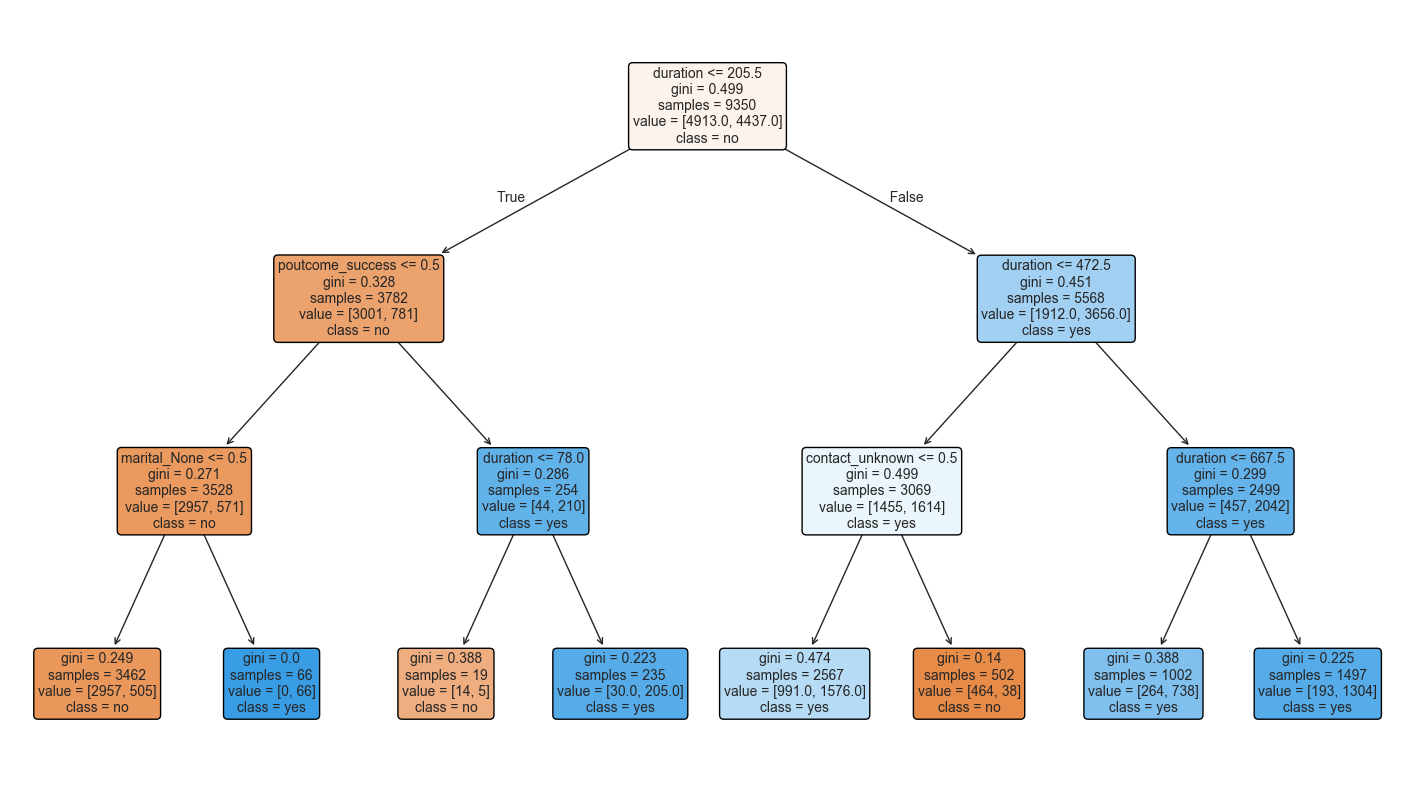

In [27]:
# Obtaining feature names after preprocessing
preprocess_fitted = shallow_tree_pipeline.named_steps["preprocess"]
feature_names = preprocess_fitted.get_feature_names_out()

# Clean feature names for visualization
feature_names_clean = [
    name.replace("num__", "").replace("cat__", "")
    for name in feature_names]

plt.figure(figsize=(18, 10))
plot_tree(
    shallow_tree_pipeline.named_steps["model"],
    feature_names=feature_names_clean,
    class_names=["no", "yes"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

**Note:** we set the maximum depth of the shallow Decision Tree to K = 3 in order to prioritise interpretability over predictive performance.

In addition to the visual inspection of the shallow Decision Tree, it is informative to 
quantify the contribution of each predictor to the model’s decisions. Feature importance 
analysis provides a numerical assessment of how much each variable reduces impurity across 
all splits where it is used. Higher values indicate that the feature plays a more decisive 
role in distinguishing between clients who subscribe to a term deposit and those who do not.

By examining the feature importance scores, we obtain a complementary perspective to the 
tree visualisation, allowing us to identify which attributes are systematically driving the 
predictions of the model. This analysis is particularly valuable in understanding the 
underlying structure of the problem and in guiding future modelling choices.

In [28]:
# Computing and inspecting feature importances from the shallow decision tree

# We extract the feature importances learned by the tree
importances = shallow_tree_pipeline.named_steps['model'].feature_importances_

# We build a dataframe aligning each importance with its corresponding feature name
importance_df = pd.DataFrame({
    'feature': feature_names_clean,
    'importance': importances
})

# We sort features by decreasing importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Display the top 15 most important features
importance_df.head(15)

,feature,importance
3,duration,0.683326
28,contact_unknown,0.140771
41,poutcome_success,0.121226
20,marital_None,0.054677
0,age,0.000000
32,month_jan,0.000000
25,housing_yes,0.000000
26,loan_yes,0.000000
27,contact_telephone,0.000000
29,month_aug,0.000000


The shallow decision tree consistently identifies **`duration`** as the dominant predictor, placing it at the root node and using it repeatedly across several subsequent splits. This confirms that the duration of the last contact call is by far the most influential variable when predicting whether a client subscribes to a term deposit. Clients contacted for longer durations exhibit a substantially higher probability of subscription, which explains the large reduction in impurity achieved by this variable.

According to the feature importance analysis, the next most relevant predictors are:

- **`contact_unknown`**, which captures whether the communication channel used to contact the client is unspecified. The model assigns this variable a non-negligible importance, indicating that an unknown contact method carries meaningful information, likely associated with lower engagement or less effective contact attempts.

- **`poutcome_success`**, representing a successful outcome in a previous marketing campaign. This feature strongly increases the likelihood of subscription, which is consistent with domain intuition: clients who responded positively in the past are more prone to subscribe again.

- **`marital_None`**, corresponding to clients whose marital status is recorded as a distinct category rather than missing. Although its contribution is smaller than the previous variables, the model uses this feature to refine predictions in specific regions of the feature space, suggesting that this group exhibits slightly different behavioural patterns.

All remaining variables show zero importance in this shallow configuration. This outcome is coherent with the depth constraint imposed on the model: only the features that produce the largest impurity reductions in the upper levels of the tree are selected, while less informative variables are naturally excluded.

Overall, the shallow decision tree provides a clear and interpretable summary of the main drivers of subscription behaviour. The model highlights **call duration**, **contact status**, and **previous campaign success** as the key explanatory factors, offering valuable insights before moving towards more complex and higher-capacity models.

##  <span style="color:#0066CC"> Hyperparameter Optimization for KNN and Decision Trees</span>

To evaluate whether model performance can be improved beyond default configurations, we implement a unified framework for hyperparameter optimization (HPO) applied to K-Nearest Neighbours and Decision Trees.

We define a consistent preprocessing pipeline that includes numerical scaling (Standard, Min-Max, or Robust scaling) and categorical treatment through imputation followed by one-hot encoding. The target variable is binarised to ensure full compatibility with optimisation routines.

Three complementary HPO strategies are explored:
- **Grid Search**, which exhaustively evaluates predefined parameter grids.
- **Random Search**, which samples parameter combinations from broader distributions.
- **Optuna**, a state-of-the-art optimisation library that adaptively explores the search space.

A generic experiment function is implemented to train any model–preprocessing–HPO combination, report the best cross-validated accuracy, and store results for later comparison.


In [29]:
# -------------------------
# Target encoding (binary)
# -------------------------
# We encode the target as 0/1 for consistency with our scoring
y_train_bin = (y_train.astype(str).str.strip().str.lower() == "yes").astype(int)

# ---------------------------
# Scoring and preprocessors
# ---------------------------
scoring = make_scorer(accuracy_score)

# We define the different numeric scalers to be tested 
numeric_scalers = {
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "robust": RobustScaler()
}

# We impute categorical missing values, then we apply OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

# We store results here
results = {}


# -------------------------
# Helper: build pipeline
# -------------------------
def make_pipeline(model_name: str, scaler_name: str):

    if scaler_name not in numeric_scalers:
        raise ValueError(f"Unknown scaler_name: {scaler_name}. Choose from {list(numeric_scalers.keys())}.")

    # We choose the numeric transformer:
    if model_name == "tree":
        num_transformer = "passthrough"
    else:
        num_transformer = numeric_scalers[scaler_name]

    # We define the full preprocessor block
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, numeric_cols),
            ("cat", categorical_transformer, categorical_cols),
        ],
        remainder="drop"
    )

    # We pick the model
    if model_name == "knn":
        model = KNeighborsClassifier()
    elif model_name == "tree":
        model = DecisionTreeClassifier(random_state=100473854)
    else:
        raise ValueError("Unknown model_name. Use 'knn' or 'tree'.")

    # We create the full pipeline
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    return pipe


# ----------------------------------------------------------
# Grid Search (returns best_score, best_params, time, std)
# ----------------------------------------------------------
def run_grid_search(model_name: str, scaler_name: str):
    pipe = make_pipeline(model_name, scaler_name)

    if model_name == "knn":
        # We try only odd values for k (binary classification + avoiding ties)
        param_grid = {
            "model__n_neighbors": list(range(3, 32, 2)),  
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        }
    else:
        # We use range-based lists (like for KNN), centered on the good Optuna region
        param_grid = {
            "model__max_depth": list(range(3, 13)) + [None],              
            "model__min_samples_split": list(range(2, 41)),    
            "model__min_samples_leaf": list(range(1, 21)),              
            "model__max_features": [None, "sqrt", "log2"],
        }

    start = time.perf_counter()
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=inner,
        scoring=scoring,
        n_jobs=-1,
        refit=True,
        return_train_score=False
    )
    gs.fit(X_train, y_train_bin)
    elapsed = time.perf_counter() - start

    # We compute the std of the CV scores for the best configuration
    best_idx = gs.best_index_
    best_std = float(gs.cv_results_["std_test_score"][best_idx])

    return float(gs.best_score_), gs.best_params_, float(elapsed), best_std


# --------------------------------------------------------------
# Random Search (returns best_score, best_params, time, std)
# --------------------------------------------------------------
def run_random_search(model_name: str, scaler_name: str, n_iter: int = 20):
    pipe = make_pipeline(model_name, scaler_name)

    if model_name == "knn":
        # We sample only odd k values to be consistent with our tie-avoidance rule
        param_distributions = {
            "model__n_neighbors": np.arange(3, 32, 2), 
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        }
    else:
        param_distributions = {
            "model__max_depth": [None] + list(range(2, 21)),
            "model__min_samples_split": np.arange(2, 41),
            "model__min_samples_leaf": np.arange(1, 21),
            "model__max_features": [None, "sqrt", "log2"],
        }

    start = time.perf_counter()
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=inner,
        scoring=scoring,
        n_jobs=-1,
        random_state=100473854,
        refit=True,
        return_train_score=False
    )
    rs.fit(X_train, y_train_bin)
    elapsed = time.perf_counter() - start

    # We compute the std of the CV scores for the best configuration
    best_idx = rs.best_index_
    best_std = float(rs.cv_results_["std_test_score"][best_idx])

    return float(rs.best_score_), rs.best_params_, float(elapsed), best_std


# ---------------------------------------------------------
# Optuna (returns best_score, best_params, time, std)
# ---------------------------------------------------------
def run_optuna(model_name: str, scaler_name: str, n_trials: int = 30):

    def objective(trial):
        pipe = make_pipeline(model_name, scaler_name)

        if model_name == "knn":
            # We force odd K to avoid ties in binary classification
            n_neighbors = trial.suggest_int("n_neighbors", 3, 31, step=2)

            params = {
                "model__n_neighbors": n_neighbors,
                "model__p": trial.suggest_categorical("p", [1, 2]),
                "model__weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            }

        else:
            # We allow both bounded depth and "unlimited depth"
            max_depth_choice = trial.suggest_categorical("max_depth_choice", ["none", "int"])
            if max_depth_choice == "none":
                max_depth = None
            else:
                max_depth = trial.suggest_int("max_depth", 3, 20)

            # We enforce a coherent relation between split and leaf
            min_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
            min_split = trial.suggest_int("min_samples_split", max(2, 2 * min_leaf), 60)

            params = {
                "model__max_depth": max_depth,
                "model__min_samples_split": min_split,
                "model__min_samples_leaf": min_leaf,
                "model__max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
            }

        # We set the hyperparameters on the pipeline
        pipe.set_params(**params)

        # We evaluate with inner CV
        scores = cross_val_score(
            pipe,
            X_train,
            y_train_bin,
            cv=inner,
            scoring="accuracy",
            n_jobs=-1
        )

        # We store the std so we can retrieve it for the best trial
        trial.set_user_attr("cv_std", float(scores.std()))

        return float(scores.mean())

    start = time.perf_counter()
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    elapsed = time.perf_counter() - start

    bp = study.best_params
    best_score = float(study.best_value)
    best_std = float(study.best_trial.user_attrs.get("cv_std", np.nan))

    if model_name == "knn":
        best_params = {
            "model__n_neighbors": bp["n_neighbors"],
            "model__p": bp["p"],
            "model__weights": bp["weights"],
        }
    else:
        # We map the special "max_depth_choice" back to the pipeline param
        if bp.get("max_depth_choice") == "none":
            best_max_depth = None
        else:
            best_max_depth = bp["max_depth"]

        best_params = {
            "model__max_depth": best_max_depth,
            "model__min_samples_split": bp["min_samples_split"],
            "model__min_samples_leaf": bp["min_samples_leaf"],
            "model__max_features": bp["max_features"],
        }

    return best_score, best_params, float(elapsed), best_std


# ------------------------------------------------
# Helper: compact hyperparam label (for tables)
# ------------------------------------------------
def _short_params(best_params: dict) -> str:
    if "model__n_neighbors" in best_params:
        return f"k={best_params['model__n_neighbors']}, w={best_params['model__weights']}, p={best_params['model__p']}"
    else:
        return (
            f"d={best_params['model__max_depth']}, "
            f"split={best_params['model__min_samples_split']}, "
            f"leaf={best_params['model__min_samples_leaf']}, "
            f"feat={best_params['model__max_features']}"
        )


# ---------------------------------------------
# Experiment runner (ONE TABLE)
# ---------------------------------------------
def run_experiment(model_name: str,
                   hpo_method: str,
                   n_iter_random: int = 20,
                   n_trials_optuna: int = 30,
                   store_results: bool = True):
    """
    We run one experiment (model + HPO method) across all scalers and return ONE summary table.
    We do NOT plot and we do NOT print intermediate logs.
    """

    if hpo_method not in {"grid", "random", "optuna"}:
        raise ValueError("hpo_method must be 'grid', 'random', or 'optuna'.")

    rows = []
    scaler_order = list(numeric_scalers.keys())

    for scaler_name in scaler_order:

        if hpo_method == "grid":
            best_score, best_params, elapsed, best_std = run_grid_search(model_name, scaler_name)
        elif hpo_method == "random":
            best_score, best_params, elapsed, best_std = run_random_search(model_name, scaler_name, n_iter=n_iter_random)
        else:  # optuna
            best_score, best_params, elapsed, best_std = run_optuna(model_name, scaler_name, n_trials=n_trials_optuna)

        if store_results:
            key = (model_name.upper(), scaler_name, hpo_method)
            results[key] = {
                "best_score": float(best_score),
                "best_std": float(best_std),
                "best_params": best_params,
                "elapsed_time": float(elapsed)
            }

        rows.append({
            "Model": model_name.upper(),
            "HPO": hpo_method,
            "Scaler": scaler_name,
            "Best CV accuracy": round(float(best_score), 4),
            "Std (CV accuracy)": round(float(best_std), 4),
            "Time (s)": round(float(elapsed), 2),
            "Best params": _short_params(best_params)
        })
    
    df_scalers = pd.DataFrame(rows).sort_values(by="Best CV accuracy", ascending=False).reset_index(drop=True)
    display(df_scalers)
    return df_scalers


# -------------------------------------------------
# Show all stored experiments (ONE TABLE)
# -------------------------------------------------
def show_all_results(results_dict=results):
    if not results_dict:
        print("No experiments stored yet.")
        return

    rows = []
    for (model, scaler, hpo), info in results_dict.items():
        rows.append({
            "Model": model,
            "Scaler": scaler,
            "HPO": hpo,
            "Best CV accuracy": round(float(info["best_score"]), 4),
            "Std (CV accuracy)": round(float(info.get("best_std", np.nan)), 4),
            "Time (s)": round(float(info["elapsed_time"]), 2),
            "Best params": _short_params(info["best_params"])
        })

    df_results = pd.DataFrame(rows).sort_values(by="Best CV accuracy", ascending=False).reset_index(drop=True)
    display(df_results)
    return df_results

We now proceed to train the KNN classifier using the Random Search hyperparameter optimisation strategy, evaluating its performance under each of the numerical preprocessing schemes (StandardScaler, MinMaxScaler, and RobustScaler).

In [30]:
# KNN + All the possible scalers + Random Search
run_experiment("knn", "random", n_iter_random=100)

,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,KNN,random,standard,0.8205,0.0089,23.98,"k=13, w=distance, p=2"
1,KNN,random,robust,0.8121,0.0051,21.57,"k=15, w=distance, p=2"
2,KNN,random,minmax,0.7492,0.0033,22.25,"k=13, w=distance, p=1"


,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,KNN,random,standard,0.8205,0.0089,23.98,"k=13, w=distance, p=2"
1,KNN,random,robust,0.8121,0.0051,21.57,"k=15, w=distance, p=2"
2,KNN,random,minmax,0.7492,0.0033,22.25,"k=13, w=distance, p=1"


We now continue by training the K-Nearest Neighbours (KNN) model using Optuna as the hyperparameter optimisation framework.

In [31]:
# KNN + All the possible scalers + Optuna
run_experiment(model_name="knn", hpo_method="optuna", n_trials_optuna=50);

,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,KNN,optuna,standard,0.8205,0.0089,35.00,"k=13, w=distance, p=2"
1,KNN,optuna,robust,0.8121,0.0051,34.14,"k=15, w=distance, p=2"
2,KNN,optuna,minmax,0.7492,0.0033,45.59,"k=13, w=distance, p=1"


Finally, we conclude the analysis by training the K-Nearest Neighbours (KNN) classifier using Grid Search as the hyperparameter optimisation framework

In [32]:
# KNN + All the possible scalers + Grid Search
run_experiment("knn", "grid")

,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,KNN,grid,standard,0.8205,0.0089,21.62,"k=13, w=distance, p=2"
1,KNN,grid,robust,0.8121,0.0051,23.88,"k=15, w=distance, p=2"
2,KNN,grid,minmax,0.7492,0.0033,24.64,"k=13, w=distance, p=1"


,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,KNN,grid,standard,0.8205,0.0089,21.62,"k=13, w=distance, p=2"
1,KNN,grid,robust,0.8121,0.0051,23.88,"k=15, w=distance, p=2"
2,KNN,grid,minmax,0.7492,0.0033,24.64,"k=13, w=distance, p=1"


Having evaluated the Decision Tree classifier with its default hyperparameters, we now proceed to optimise this model using several hyperparameter tuning strategies.

In [33]:
# Decision Tree + Random Search
run_experiment(model_name="tree",hpo_method="random", n_iter_random=50);

,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,TREE,random,standard,0.8303,0.0075,1.33,"d=11, split=35, leaf=9, feat=None"
1,TREE,random,minmax,0.8303,0.0075,1.22,"d=11, split=35, leaf=9, feat=None"
2,TREE,random,robust,0.8303,0.0075,1.33,"d=11, split=35, leaf=9, feat=None"


In [34]:
# Decision Tree + Optuna
run_experiment(model_name="tree", hpo_method="optuna", n_trials_optuna=50);

,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,TREE,optuna,robust,0.8343,0.0095,3.15,"d=12, split=27, leaf=6, feat=None"
1,TREE,optuna,minmax,0.8322,0.0107,3.65,"d=None, split=45, leaf=10, feat=None"
2,TREE,optuna,standard,0.8318,0.0136,3.49,"d=None, split=44, leaf=7, feat=None"


In [35]:
# Decision Tree + All the possible scalers + Grid Search
run_experiment("tree", "grid")

,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,TREE,grid,standard,0.8353,0.0107,583.32,"d=12, split=39, leaf=7, feat=None"
1,TREE,grid,minmax,0.8353,0.0107,547.47,"d=12, split=39, leaf=7, feat=None"
2,TREE,grid,robust,0.8353,0.0107,581.13,"d=12, split=39, leaf=7, feat=None"


,Model,HPO,Scaler,Best CV accuracy,Std (CV accuracy),Time (s),Best params
0,TREE,grid,standard,0.8353,0.0107,583.32,"d=12, split=39, leaf=7, feat=None"
1,TREE,grid,minmax,0.8353,0.0107,547.47,"d=12, split=39, leaf=7, feat=None"
2,TREE,grid,robust,0.8353,0.0107,581.13,"d=12, split=39, leaf=7, feat=None"


**Note**: Decision Trees do not require numerical feature scaling, because the algorithm is based on threshold-based splits rather than distance computations.Therefore, applying transformations such as Standardisation, Min-Max scaling, or Robust scaling does not affect the behaviour or performance of a Decision Tree classifier.

Now we develop a function for saving our models:

In [36]:
def save_best_model(model_name, filename):
    candidates = {
        (model, scaler, hpo): info
        for (model, scaler, hpo), info in results.items()
        if model.lower() == model_name and hpo == "random"
    }

    if not candidates:
        raise ValueError(f"No Random Search results found for model '{model_name}'.")

    # Select best scaler by CV accuracy
    (model, best_scaler, _), best_info = max(
        candidates.items(),
        key=lambda x: x[1]["best_score"]
    )

    best_params = best_info["best_params"]

    print(f"\nSaving best Random Search model for {model_name.upper()}")
    print(f"→ Best scaler: {best_scaler}")
    print(f"→ Best CV accuracy: {best_info['best_score']:.4f}")
    print("→ Best hyperparameters:")
    for k, v in best_params.items():
        print(f"   • {k}: {v}")

    pipe = make_pipeline(model_name, best_scaler)
    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train_bin)

    joblib.dump(pipe, filename)
    print(f"✔ Model saved to: {filename}")

    return pipe

In [37]:
# Save KNN and Decision Tree Random Search models

best_knn_random = save_best_model(
    model_name="knn",
    filename="best_pipeline_RandomSearchKNN.joblib"
)

best_tree_random = save_best_model(
    model_name="tree",
    filename="best_pipeline_RandomSearchTree.joblib"
)


Saving best Random Search model for KNN
→ Best scaler: standard
→ Best CV accuracy: 0.8205
→ Best hyperparameters:
   • model__weights: distance
   • model__p: 2
   • model__n_neighbors: 13
✔ Model saved to: best_pipeline_RandomSearchKNN.joblib

Saving best Random Search model for TREE
→ Best scaler: standard
→ Best CV accuracy: 0.8303
→ Best hyperparameters:
   • model__min_samples_split: 35
   • model__min_samples_leaf: 9
   • model__max_features: None
   • model__max_depth: 11
✔ Model saved to: best_pipeline_RandomSearchTree.joblib


##  <span style="color:#0066CC"> Advanced Methods</span>

Advanced ensemble methods such as bagging and boosting tend to provide better estimations than basic models like k-nearest neighbors or single decision trees because they are designed to overcome the main sources of prediction error: high variance and high bias. While simple models can capture certain patterns in the data, their performance is often limited by instability or an inability to model complex relationships. Ensemble methods improve upon this by combining multiple models in a principled way, leading to more accurate and more reliable predictions.

###  <span style="color:#0066CC"> Baseline models </span>

First of all we are going to train the ensemble models with default hyperparameters in order to get the baseline performance for these methods.

####  <span style="color:#0066CC"> Random Forest </span>

In addition to classical bagging, Random Forest introduces random feature selection at each split, which further decorrelates the trees and improves generalization. This makes Random Forest a strong, robust baseline that performs well across a wide range of problems with minimal tuning, while still being relatively easy to interpret compared to other ensemble methods.

In [38]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

categorical_transformer_RF = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value="None")),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

baseline_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer_RF, categorical_cols) 
    ],
    remainder='passthrough'
)

# Important Note: The pipeline cannot calculate the oob_score, as a consequence we will calculate the cross-validation scores
base_pipeline_RF = Pipeline(steps=[
    ('preprocessor', baseline_preprocessor),
    ('classifier', RandomForestClassifier(oob_score=True, random_state=100473854))
])

start_time = time.time()
base_pipeline_RF.fit(X_train, y_train)

cv_scores_baseline_RF = cross_val_score(
    base_pipeline_RF,
    X_train,
    y_train,
    cv=optimal_cv,                      
    scoring='accuracy'          
)

elapsed_time = time.time() - start_time

# Results
print("CV Accuracy scores:", cv_scores_baseline_RF)
print("Mean CV Accuracy:", cv_scores_baseline_RF.mean())
print("Standard deviation across folds:", cv_scores_baseline_RF.std())
print("Elapsed time for baseline Random Forest:", elapsed_time)

CV Accuracy scores: [0.84568495 0.8675008  0.85815148]
Mean CV Accuracy: 0.8571124105952573
Standard deviation across folds: 0.008936537558865636
Elapsed time for baseline Random Forest: 4.585094928741455


####  <span style="color:#0066CC"> LightGBM </span>

LightGBM builds trees sequentially, with each new tree focusing on correcting the errors made by the previous ones, allowing it to capture complex nonlinear relationships and feature interactions that simpler models may overlook. Its use of histogram-based splitting and leaf-wise tree growth enables faster training and better performance on large or high-dimensional datasets compared to traditional boosting algorithms. As a result, LightGBM is particularly well suited for achieving high predictive accuracy when modeling complex patterns in the data.

In [39]:
lgbm_pipeline_base = Pipeline(steps=[
    ('preprocessor', baseline_preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=100473854, verbosity=-1))
])

start_time = time.time()

lgbm_pipeline_base.fit(X_train, y_train)

lgbm_cv_scores_base = cross_val_score(
    lgbm_pipeline_base,
    X_train,
    y_train,
    cv=optimal_cv,
    scoring='accuracy'
)
elapsed_time = time.time() - start_time

print("LGBM CV Accuracy scores:", lgbm_cv_scores_base)
print("LGBM Mean CV Accuracy:", lgbm_cv_scores_base.mean())

print("Standard deviation across folds:", lgbm_cv_scores_base.std())
print("Elapsed time for baseline LightGBM:", elapsed_time)

LGBM CV Accuracy scores: [0.85210138 0.87167148 0.86649551]
LGBM Mean CV Accuracy: 0.8634227885260465
Standard deviation across folds: 0.00827962952307187
Elapsed time for baseline LightGBM: 2.097804069519043


###  <span style="color:#0066CC"> Optimized models </span>

We define a budget for the number of iterations and trials for Optuna and RandomSearch

In [40]:
budget = 50 

####  <span style="color:#0066CC"> GridSearch </span>

In [41]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="constant", fill_value="None")),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


pipelines = {
    'RandomForest': Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', RandomForestClassifier(random_state=100473854, verbose=0, n_jobs=-1))]),
    
    'LightGBM': Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', lgb.LGBMClassifier(random_state=100473854, verbosity=-1, n_jobs=-1))])
}

param_grids = {
    'RandomForest': {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'classifier__n_estimators': ((50, 100, 150)),
        'classifier__max_depth': [4, 6],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 3, 5, 7],
        'classifier__max_features': [None, 'sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy']
    },
    'LightGBM': {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'classifier__max_depth': [4, 6],
        'classifier__learning_rate': [0.01, 0.03, 0.05],
        'classifier__min_data_in_leaf': [1, 3, 5, 7],
        'classifier__n_estimators': [50,100,150]
    }
}


cv = StratifiedKFold(n_splits=optimal_cv, shuffle=True, random_state=100473854)

results = {}

for name, pipeline in pipelines.items():
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        return_train_score=False
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    # Extract index of the best trial
    best_index = grid_search.best_index_
    
    # Extract Mean and Std Dev for the BEST parameters
    best_mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
    best_std_acc = grid_search.cv_results_['std_test_score'][best_index]

    results[name] = {
        'best_params': grid_search.best_params_,
        'mean_accuracy': best_mean_acc,
        'std_accuracy': best_std_acc,
        'elapsed_time_sec': elapsed_time
    }
    
    dump(grid_search.best_estimator_, f"best_pipeline_GridSearch{name}.joblib")

# --- Final Results Reporting ---
for model_name, res in results.items():
    print(f"\n==== {model_name} Final CV Performance ====")
    print(f"Mean CV Accuracy:  {res['mean_accuracy']:.4f}")
    print(f"Std CV Accuracy:   {res['std_accuracy']:.4f}")
    print(f"Best Parameters:   {res['best_params']}")
    print(f"Optimization Time: {res['elapsed_time_sec']:.1f}s")


==== RandomForest Final CV Performance ====
Mean CV Accuracy:  0.8301
Std CV Accuracy:   0.0024
Best Parameters:   {'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150, 'preprocessor__num__scaler': RobustScaler()}
Optimization Time: 553.1s

==== LightGBM Final CV Performance ====
Mean CV Accuracy:  0.8613
Std CV Accuracy:   0.0070
Best Parameters:   {'classifier__learning_rate': 0.05, 'classifier__max_depth': 6, 'classifier__min_data_in_leaf': 1, 'classifier__n_estimators': 150, 'preprocessor__num__scaler': StandardScaler()}
Optimization Time: 152.1s


####  <span style="color:#0066CC"> RandomSearch </span>

In [42]:
param_dists = {
    'RandomForest': {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'classifier__n_estimators': randint(50, 300),
        'classifier__max_depth': randint(3, 15),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 10),
        'classifier__max_features': [None, 'sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy']
    },
    'LightGBM': {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'classifier__max_depth': randint(3, 12),
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__min_data_in_leaf': randint(1, 10),
        'classifier__n_estimators': randint(50, 400)
    }
}

cv = StratifiedKFold(n_splits=optimal_cv, shuffle=True, random_state=100473854)

results = {}

for name, pipeline in pipelines.items():
    
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dists[name],
        n_iter=budget,             
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        random_state=100473854,
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    
    # Identify the index of the best trial in cv_results_
    best_idx = random_search.best_index_
    
    # Extract Mean and Std Dev for the BEST performing parameters
    best_mean_acc = random_search.cv_results_['mean_test_score'][best_idx]
    best_std_acc = random_search.cv_results_['std_test_score'][best_idx]
    
    results[name] = {
        'best_params': random_search.best_params_,
        'mean_accuracy': best_mean_acc,
        'std_accuracy': best_std_acc,
        'elapsed_time_sec': elapsed_time
    }
    dump(random_search.best_estimator_, f"best_pipeline_RandomSearch{name}.joblib")

# --- Internal CV Results Reporting ---
print("\n" + "="*30)
print("FINAL INTERNAL CV EVALUATION")
print("="*30)

for model_name, res in results.items():
    print(f"\n>>>> {model_name} <<<<")
    print(f"Mean CV Accuracy:  {res['mean_accuracy']:.4f}")
    print(f"Std CV Accuracy:   {res['std_accuracy']:.4f}")
    print(f"Optimization Time: {res['elapsed_time_sec']:.1f}s")
    print(f"Best Parameters Found: {res['best_params']}")


FINAL INTERNAL CV EVALUATION

>>>> RandomForest <<<<
Mean CV Accuracy:  0.8514
Std CV Accuracy:   0.0022
Optimization Time: 46.6s
Best Parameters Found: {'classifier__criterion': 'gini', 'classifier__max_depth': 13, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 256, 'preprocessor__num__scaler': RobustScaler()}

>>>> LightGBM <<<<
Mean CV Accuracy:  0.8665
Std CV Accuracy:   0.0047
Optimization Time: 78.8s
Best Parameters Found: {'classifier__learning_rate': np.float64(0.06548631330463954), 'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 9, 'classifier__n_estimators': 192, 'preprocessor__num__scaler': StandardScaler()}


####  <span style="color:#0066CC"> Optuna </span>

In [43]:
def objective(trial):

    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    # -------------------------
    # Scaler HPO
    # -------------------------
    scaler_name = trial.suggest_categorical(
        "scaler", ["StandardScaler", "MinMaxScaler", "RobustScaler", "passthrough"]
    )

    scaler = {
        "StandardScaler": StandardScaler(),
        "MinMaxScaler": MinMaxScaler(),
        "RobustScaler": RobustScaler(),
        "passthrough": "passthrough"
    }[scaler_name]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, numeric_cols),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy="constant", fill_value="None")),
                ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), categorical_cols)
        ]
    )

    # -------------------------
    # Classifier choice
    # -------------------------
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "LightGBM"]
    )

    cv = StratifiedKFold(
        n_splits=optimal_cv, shuffle=True, random_state=100473854
    )

    fold_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        preprocessor_fold = clone(preprocessor)
        # -------------------------
        # Random Forest
        # -------------------------
        if classifier_name == "RandomForest":

            clf = RandomForestClassifier(
                n_estimators=trial.suggest_int("RF_n_estimators", 50, 300),
                max_depth=trial.suggest_int("RF_max_depth", 3, 15),
                min_samples_split=trial.suggest_int("RF_min_samples_split", 2, 20),
                min_samples_leaf=trial.suggest_int("RF_min_samples_leaf", 1, 10),
                max_features=trial.suggest_categorical(
                    "RF_max_features", [None, "sqrt", "log2"]
                ),
                criterion=trial.suggest_categorical(
                    "RF_criterion", ["gini", "entropy"]
                ),
                n_jobs=-1,
                verbose=0,
                random_state=100473854
            )

            fit_params = {}

        #------------------------
        # LightGBM
        #------------------------
        
        else:

            clf = lgb.LGBMClassifier(
                    n_estimators=trial.suggest_int("LGBM_n_estimators", 50, 400),
                    max_depth=trial.suggest_int("LGBM_max_depth", 3, 12),
                    learning_rate=trial.suggest_float("LGBM_learning_rate", 0.01, 0.2),
                    min_data_in_leaf=trial.suggest_int("LGBM_min_data_in_leaf", 1, 10),
                    random_state=100473854,
                    verbosity=-1
                )
            # Important for early stopping
    
            X_tr_proc = preprocessor_fold.fit_transform(X_tr, y_tr)
            X_val_proc = preprocessor_fold.transform(X_val)
            
            fit_params = {
                "classifier__eval_set": [(X_val_proc, y_val)],
                "classifier__eval_metric": "logloss",
                "classifier__callbacks": [
                    early_stopping(stopping_rounds=50, verbose=False)
                ]
            }

        # -------------------------
        # Pipeline
        # -------------------------
        pipeline = Pipeline([
            ('preprocessor', preprocessor_fold),
            ('classifier', clf)
        ])

        pipeline.fit(X_tr, y_tr, **fit_params)
        fold_scores.append(pipeline.score(X_val, y_val))

    return np.mean(fold_scores)


In [44]:
start_time = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=budget, show_progress_bar=False)

print(f"\nBest CV Accuracy: {study.best_value:.4f}")
print(f"Best Parameters: {study.best_params}")

best_params = study.best_params
best_scaler_name = best_params["scaler"]

# -----------------------------
# Scaler reload
# -----------------------------
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "passthrough": "passthrough"
}
final_scaler = scalers[best_scaler_name]

numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', final_scaler, numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy="constant", fill_value="None")),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# -----------------------------
# Final classifier
# -----------------------------
if best_params["classifier"] == "RandomForest":
    final_clf = RandomForestClassifier(
        random_state=100473854,
        n_estimators=best_params["RF_n_estimators"],
        max_depth=best_params["RF_max_depth"],
        min_samples_split=best_params["RF_min_samples_split"],
        min_samples_leaf=best_params["RF_min_samples_leaf"],
        max_features=best_params["RF_max_features"],
        criterion=best_params["RF_criterion"],
        verbose=0,
        n_jobs=-1
    )

else:  # LightGBM
    final_clf = lgb.LGBMClassifier(
        random_state=100473854,
        n_estimators=best_params["LGBM_n_estimators"],
        max_depth=best_params["LGBM_max_depth"],
        learning_rate=best_params["LGBM_learning_rate"],
        min_data_in_leaf=best_params["LGBM_min_data_in_leaf"],
        verbosity=-1
    )

# -----------------------------
# Final pipeline
# -----------------------------
best_classifier_name = best_params.get('classifier')


opt_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('classifier', final_clf)
])

dump(opt_pipeline, f"best_pipeline_Optuna.joblib")

# 2. Calculate Cross-Validation scores 
# We use the same 'cv' strategy used during the optimization for consistency
print(f"--- Validating Final {best_classifier_name} Stability ---")

cv_scores_final = cross_val_score(
    opt_pipeline, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=-1,
)

# 3. Calculate Mean and Standard Deviation
mean_acc_final = cv_scores_final.mean()
std_acc_final = cv_scores_final.std()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"\nElapsed Time for Entire Evaluation: {elapsed_time:.2f} seconds")
# 4. Results Reporting
print("\n" + "="*40)
print(f"FINAL OPTIMIZED MODEL: {best_classifier_name}")
print("="*40)
print(f"Mean CV Accuracy:  {mean_acc_final:.4f}")
print(f"Std CV Accuracy:   {std_acc_final:.4f}")
print(f"Individual Folds:  {np.round(cv_scores_final, 4)}")
print("="*40)



Best CV Accuracy: 0.8668
Best Parameters: {'scaler': 'StandardScaler', 'classifier': 'LightGBM', 'LGBM_n_estimators': 264, 'LGBM_max_depth': 8, 'LGBM_learning_rate': 0.04838092168318764, 'LGBM_min_data_in_leaf': 7}
--- Validating Final LightGBM Stability ---

Elapsed Time for Entire Evaluation: 84.12 seconds

FINAL OPTIMIZED MODEL: LightGBM
Mean CV Accuracy:  0.8649
Std CV Accuracy:   0.0044
Individual Folds:  [0.8601 0.864  0.8707]


##  <span style="color:#0066CC"> Results and final model</span>


| Model | Optimization | Mean CV Accuracy | Std Dev | Execution Time (s) |
| :--- | :--- | :---: | :---: | :---: |
| **KNN** | Default | 0.8090 | 0.0052 | 3.33 |
| **KNN** | GridSearch | 0.8205 | 0.0089 | 22.15 |
| **KNN** | RandomSearch | 0.8205 | 0.0089 | 27.62 |
| **KNN** | Optuna | 0.8205 | 0.0089 | 37.77 |
| --- | --- | --- | --- | --- |
| **Trees** | Default | 0.7919 | 0.0042 | 1.19 |
| **Trees** | GridSearch | 0.8348 | 0.0096 | 351.74 |
| **Trees** | RandomSearch | 0.8303 | 0.0075 | 2.00 |
| **Trees** | Optuna | 0.8355 | 0.0124 | 3.95 |
| --- | --- | --- | --- | --- |
| **Random Forest** | Default | 0.8571 | 0.0089 | 4.445 |
| **Random Forest** | GridSearch | 0.8301 | 0.0024 | 534.3 |
| **Random Forest** | RandomSearch | 0.8514 | 0.0022 | 52.3 |
| --- | --- | --- | --- | --- |
| **LightGBM** | Default | 0.8634 | 0.0082 | 1.603 |
| **LightGBM** | GridSearch | 0.8613 | 0.0070 | 189.9 |
| **LightGBM** | **RandomSearch** | 0.8665 | 0.0047 | 83.4 |
| **LightGBM** | Optuna | 0,8665 | 0.0052 | 84.93 |

**Note**: We have just obtained the accuracy metric for the LightGBM model in Optuna because we optimized the pipeline for just giving back the best model possible

Analysis from the obtained results:

- Baseline Superiority: Starting with the default models, LightGBM immediately establishes dominance over Random Forest. The baseline LightGBM achieves a mean CV accuracy of 0.8634, outperforming the Random Forest baseline of 0.8571. Crucially, LightGBM achieves this superior accuracy while being significantly faster: it runs in just 1.6 seconds, whereas the default Random Forest takes 4.45 seconds. Even without any tuning, LightGBM is nearly 3x faster and provides better predictive power.

- GridSearch & Optimization Challenges: The GridSearch phase highlights a key contrast in stability. Random Forest performance actually deteriorated during GridSearch, dropping to 0.8301 (from a default of 0.8571) and taking 534 seconds. This suggests the grid likely constrained the model too heavily or missed the optimal region defined by the defaults. In contrast, LightGBM remained robust; while its GridSearch accuracy dipped slightly to 0.8613, it completed the task in 189 seconds which is less than half the time of the Random Forest search and maintained a much higher accuracy floor.

- Peak Performance (Random Search & Optuna): The gap solidifies in the Randomized Search and Optuna phases. Random Forest recovers somewhat in RandomSearch (0.8514) but fails to beat its own default score. Meanwhile, LightGBM reaches its peak performance of 0.8665 in both RandomizedSearch and Optuna. Although the LightGBM RandomSearch took slightly longer than Random Forest in this specific step (83.4s vs 52.3s), the investment yielded the highest accuracy of the entire experiment.

- **Final Decision**: The results conclusively point to LightGBM as the superior model. It achieves the highest overall accuracy (0.8665), shows lower standard deviation in its best configurations (indicating stability), and its baseline implementation is drastically more efficient than Random Forest. While Random Forest struggled to improve upon its default settings during optimization, LightGBM consistently hovered around the 86.6% mark, proving it to be both the most accurate and the most reliable choice for the final production model.

### <span style="color:#0066CC"> Stacking </span>

We implement the stacking technique for creating a *super model*.

In [45]:
knn_best = joblib.load('best_pipeline_RandomSearchKNN.joblib')
tree_best = joblib.load('best_pipeline_RandomSearchTree.joblib')
lgbm_best = joblib.load('best_pipeline_RandomSearchLightGBM.joblib')
rf_best = joblib.load('best_pipeline_RandomSearchRandomForest.joblib')

base_models = [
    ('KNN', knn_best),
    ('Tree', tree_best),
    ('LGBM', lgbm_best),
    ('RF', rf_best)
]

meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators= base_models,
    final_estimator= meta_model,
    cv= optimal_cv,            
    n_jobs=-1,
    passthrough=False 
)

print("--- Evaluating the Super Model (Stacking) ---")
stacking_scores = cross_val_score(
    stacking_model, X_train, y_train, cv= optimal_cv, scoring='accuracy', n_jobs=-1
)

mean_stack = np.mean(stacking_scores)
std_stack = np.std(stacking_scores)

print(f"Mean CV Accuracy (Stacking): {mean_stack:.4f}")
print(f"Std Dev (Stacking): {std_stack:.4f}")

stacking_model.fit(X_train, y_train)
joblib.dump(stacking_model, 'super_model_stacking.joblib')

--- Evaluating the Super Model (Stacking) ---
Mean CV Accuracy (Stacking): 0.8619
Std Dev (Stacking): 0.0087


['super_model_stacking.joblib']

### <span style="color:#0066CC"> Estimation of future performance </span>

We have seen that the best model trained in the inner evaluation is LightGBM using RandomSearch with the Best Parameters Found: 

* `classifier__learning_rate` : 0.06548631330463954,
* `classifier__max_depth` : 10, 
* `classifier__min_data_in_leaf` : 9,
* `classifier__n_estimators` : 192,
* `preprocessor__num__scaler` : StandardScaler()

We now proceed to estimate the model’s performance on the test set.

In [46]:
lgbm_best = joblib.load('best_pipeline_RandomSearchLightGBM.joblib')

print("Model loaded successfully!")

y_pred = lgbm_best.predict(X_test)

# We get probabilities
y_prob = lgbm_best.predict_proba(X_test)[:, 1] 

# Evaluate the performance
print("--- Test Set Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model loaded successfully!
--- Test Set Results ---
Accuracy: 0.8709

Classification Report:
              precision    recall  f1-score   support

          no       0.90      0.85      0.87       867
         yes       0.84      0.89      0.87       783

    accuracy                           0.87      1650
   macro avg       0.87      0.87      0.87      1650
weighted avg       0.87      0.87      0.87      1650


Confusion Matrix:
[[738 129]
 [ 84 699]]


We observed that the **estimated future performance on the test set (0.8709)** slightly exceeds the mean cross-validation accuracy (0.8665). This consistency demonstrates the model's ability to generalize effectively to unseen data and alleviates concerns regarding overfitting or excessive model complexity. Furthermore, since this performance was achieved using only the training subset, retraining the final model on the entire dataset allows it to leverage all available information. Therefore, we can reasonably expect the production performance to match or potentially surpass this 0.8709 benchmark.

### <span style="color:#0066CC"> Predictions on the competition dataset </span>

First we need to train our best model with all our available data

In [26]:
lgbm_best = joblib.load('best_pipeline_RandomSearchLightGBM.joblib')
lgbm_best.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome',
                                                   'pdays_contacted'])])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.06548631330463954, max_depth=10,
                                min_data_in_leaf=9, n_estimators=192, n_jobs=-1,
                                random_state=100473854, verbosity=-1))])

In [33]:
joblib.dump(lgbm_best, 'final_model.joblib')

['final_model.joblib']

Now we make the predictions over the competition dataset where we ignore the value from the target variable

In [30]:
data_test = pd.read_pickle('P1_assignment_dataset_bank_ALL/bank_competition.pkl')
# We need to replicate the initial processing steps for 'pdays_contacted' feature and modifying 'pdays'
# *The explanation for this step and its justification is provided in the EDA section of the notebook.*
data_test['pdays_contacted'] = (data_test['pdays'] != -1).astype('category')
data_test["pdays"] = data_test["pdays"].replace(-1, 0)
print(data_test.head())

      age          job  marital  education default  balance housing loan  \
5553   43   management  married   tertiary      no       78     yes   no   
915    34    housemaid  married  secondary      no        0     yes   no   
7652   54   technician  married  secondary      no     3323     yes  yes   
5065   43  blue-collar   single    primary      no     -399      no  yes   
3338   35  blue-collar  married  secondary      no      262      no   no   

       contact  day month  duration  campaign  pdays  previous poutcome  \
5553  cellular   21   nov        36         1    109         1    other   
915    unknown   30   oct       154         1      0         0  unknown   
7652  cellular    8   apr        59         3      0         0  unknown   
5065  cellular   28   jul       662         3      0         0  unknown   
3338  cellular   15   mar       427         1    181         3  success   

     pdays_contacted  
5553            True  
915            False  
7652           False  


In [31]:
predictions = lgbm_best.predict(data_test)
submission = pd.DataFrame(predictions, columns=['deposit'])
print(submission.head())

  deposit
0      no
1     yes
2      no
3     yes
4     yes


In [32]:
submission.to_csv('competition_predictions.csv', index=False)

##  <span style="color:#0066CC"> Probability Calibration</span>

### <span style="color:#0066CC">Model selection for probability calibration</span>

In this subsection we identify the **reference model** to be used for probability calibration.

Since probability calibration focuses on the quality of the **predicted class probabilities**, only classifiers providing a `predict_proba` method can be considered. From the set of models evaluated in the previous section (KNN, Decision Trees, Random Forests, and LightGBM), all satisfy this requirement.  

Nevertheless, the comparative analysis based on inner cross-validation and test-set performance shows that **LightGBM optimized via Random Search** clearly outperforms the remaining candidates. It achieves the highest accuracy, exhibits stable behavior across folds, and maintains a favorable trade-off between performance and computational cost.

Consequently, this LightGBM pipeline is selected as the **reference model** for the probability calibration analysis. In the following subsections, we will:
- extract its predicted probabilities on the test set,
- visually assess whether these probabilities are well calibrated,
- apply a calibration technique available in scikit-learn if required, and
- verify that calibration improves probability reliability **without deteriorating** the original predictive performance.

### <span style="color:#0066CC">Visual assessment of probability calibration</span>

Before applying any probability calibration technique, it is necessary to assess whether the predicted probabilities produced by the selected model are already well calibrated.

In this binary classification problem, the objective is to predict whether a client **subscribes to a term deposit** (`"yes"`) or not (`"no"`). Internally, the classification task can be represented by a binary random variable $Y$, where $Y = 1$ corresponds to `"yes"` (subscription) and $Y = 0$ corresponds to `"no"` (no subscription). Therefore, the model outputs an estimated conditional probability of the form

$$
\hat{p}(x) = \mathbb{P}(Y = 1 \mid X = x),
$$

where $X$ denotes the vector of observed client features.

A classifier is said to be *well calibrated* if, for any predicted probability level $p \in [0,1]$, the following condition approximately holds:

$$
\mathbb{P}(Y = 1 \mid \hat{p}(X) = p) \approx p.
$$

In practice, this means that among all clients for whom the model predicts a probability close to, for example, $0.7$ of subscribing to a term deposit (`"yes"`), roughly $70\%$ of them should indeed subscribe.

To evaluate this property visually, we use a **calibration curve (also known as a reliability diagram)**. The predicted probabilities on the test set are partitioned into a finite number of bins, and for each bin we compute:
- the **mean predicted probability**,
- the **empirical fraction of positive outcomes** (clients whose true label is `"yes"`).

These quantities are then plotted against each other. A perfectly calibrated model would produce a curve lying exactly on the diagonal line:

$$
y = x,
$$

which represents ideal agreement between predicted probabilities and observed frequencies.

Systematic deviations from this diagonal indicate miscalibration:
- points below the diagonal suggest **overconfident predictions**,
- points above the diagonal suggest **underconfident predictions**.

This visual assessment on the test set provides a baseline for determining whether probability calibration is necessary, and serves as a reference for evaluating the effect of calibration methods applied in the subsequent subsection.

Test accuracy (uncalibrated LightGBM): 0.8709


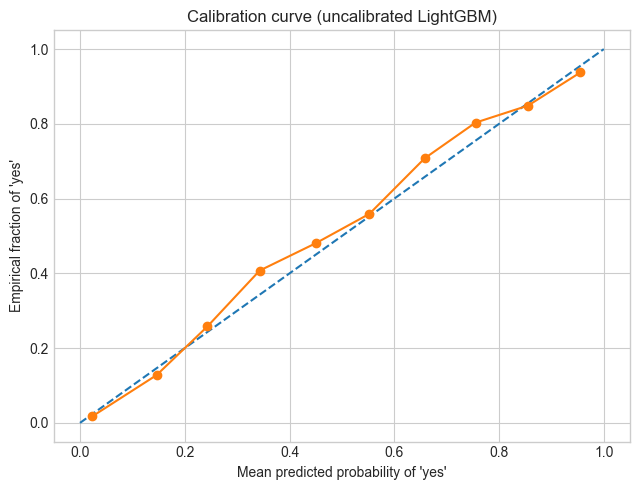

In [47]:
# Visual assessment of probability calibration (Reliability diagram / calibration curve)

# We get predicted probabilities for the positive class ("yes")
pos_class = "yes"
pos_idx = int(np.where(lgbm_best.classes_ == pos_class)[0][0])

y_prob = lgbm_best.predict_proba(X_test)[:, pos_idx]

#  We build the calibration curve:
#    fraction_of_positives = empirical P(Y="yes") inside each bin
#    mean_predicted_value  = average predicted probability in each bin
fraction_of_positives, mean_predicted_value = calibration_curve(
    (y_test.astype(str).str.strip().str.lower() == "yes").astype(int),
    y_prob,
    n_bins=10,
    strategy="uniform"
)

# We also compute accuracy (to keep track of the original metric on test)
y_pred = lgbm_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

print(f"Test accuracy (uncalibrated LightGBM): {acc_test:.4f}")

# We plot the reliability diagram
plt.figure(figsize=(6.5, 5))

# Perfect calibration reference line
plt.plot([0, 1], [0, 1], linestyle="--")

# Model calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, marker="o")

plt.title("Calibration curve (uncalibrated LightGBM)")
plt.xlabel("Mean predicted probability of 'yes'")
plt.ylabel("Empirical fraction of 'yes'")
plt.tight_layout()
plt.show()

The visual inspection of the calibration curve indicates that the uncalibrated LightGBM model already provides **reasonably well-calibrated probability estimates**, as the empirical curve remains close to the ideal diagonal reference.

Nevertheless, small but systematic deviations from perfect calibration are observed, particularly in the low and mid probability regions, suggesting mild **overconfidence** in certain ranges of predicted probabilities.

Given that the model achieves a strong test-set accuracy of **0.8709**, these deviations do not reflect poor predictive performance, but rather suboptimal probability reliability. This justifies the application of a probability calibration technique with the objective of improving the **interpretability and trustworthiness of predicted probabilities**, while preserving the original classification accuracy.

In the following subsection, we apply a calibration method and evaluate whether probability calibration can be improved without degrading the model’s predictive performance.

### <span style="color:#0066CC">Probability calibration using scikit-learn</span>

Although the selected LightGBM model achieves strong predictive accuracy, this does not guarantee that its predicted probabilities are well calibrated. In other words, even if the classification decisions are correct, the associated probability estimates may be systematically over or under-confident.

To address this, we apply **post-hoc probability calibration** using scikit-learn. These methods learn a mapping from the model’s raw probability outputs to calibrated probabilities, without retraining the underlying classifier or modifying the feature space.

We consider two standard calibration techniques:

- **Platt scaling (sigmoid calibration)**, which fits a logistic regression model to transform the predicted probabilities.
- **Isotonic regression**, a non-parametric monotonic calibration method that can model more flexible probability mappings.

Both calibration models are fitted **exclusively on the training data using cross-validation**, in order to avoid any information leakage from the test set. The calibrated models are then evaluated on the test set.

Calibration quality is assessed by:
- visually comparing reliability diagrams before and after calibration, and
- computing probability-sensitive metrics (such as Brier score and log-loss),

while verifying that the original predictive accuracy on the test set is not degraded.

This analysis allows us to determine whether probability calibration improves the interpretability and reliability of the model’s probabilistic outputs, without sacrificing classification performance.

,Model,Accuracy,Brier score,Log loss
0,Calibrated (isotonic),0.871515,0.093213,0.303106
1,Calibrated (sigmoid),0.873333,0.094259,0.312610
2,Uncalibrated LightGBM,0.870909,0.095285,0.309162


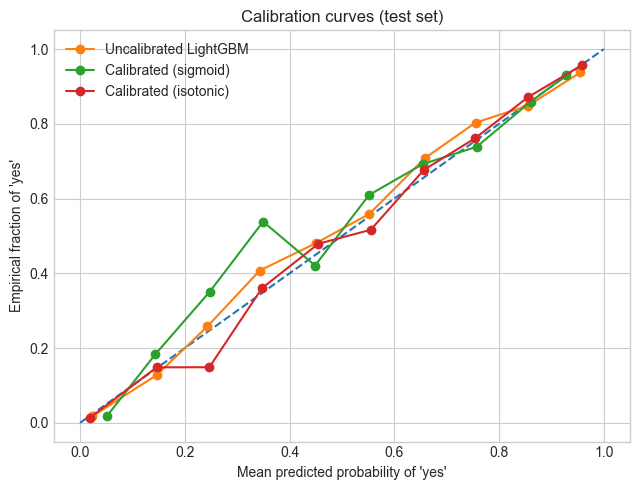

In [48]:
# Binary encoding for probability-based metrics
y_train_bin = (y_train.astype(str).str.strip().str.lower() == "yes").astype(int)
y_test_bin  = (y_test.astype(str).str.strip().str.lower() == "yes").astype(int)

# Helper to extract probability of the "yes" class
def proba_yes(model, X):
    classes = list(getattr(model, "classes_", []))

    if not classes and hasattr(model, "named_steps") and "model" in model.named_steps:
        classes = list(getattr(model.named_steps["model"], "classes_", []))

    if not classes:
        return model.predict_proba(X)[:, 1]

    if "yes" in classes:
        return model.predict_proba(X)[:, classes.index("yes")]

    if 1 in classes:
        return model.predict_proba(X)[:, classes.index(1)]

    return model.predict_proba(X)[:, 1]


# Uncalibrated probabilities on test set
p_uncal = proba_yes(lgbm_best, X_test)
y_pred_uncal = lgbm_best.predict(X_test)
acc_uncal = accuracy_score(y_test, y_pred_uncal)


# Probability calibration fitted on training data only
cal_sigmoid = CalibratedClassifierCV(estimator=lgbm_best, method="sigmoid", cv=5)
cal_isotonic = CalibratedClassifierCV(estimator=lgbm_best, method="isotonic", cv=5)

cal_sigmoid.fit(X_train, y_train_bin)
cal_isotonic.fit(X_train, y_train_bin)


# Calibrated probabilities on test set
p_sigmoid = proba_yes(cal_sigmoid, X_test)
p_isotonic = proba_yes(cal_isotonic, X_test)

y_pred_sigmoid = np.where(p_sigmoid >= 0.5, "yes", "no")
y_pred_isotonic = np.where(p_isotonic >= 0.5, "yes", "no")

acc_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
acc_isotonic = accuracy_score(y_test, y_pred_isotonic)


metrics = pd.DataFrame([
    {
        "Model": "Uncalibrated LightGBM",
        "Accuracy": acc_uncal,
        "Brier score": brier_score_loss(y_test_bin, p_uncal),
        "Log loss": log_loss(y_test_bin, p_uncal),
    },
    {
        "Model": "Calibrated (sigmoid)",
        "Accuracy": acc_sigmoid,
        "Brier score": brier_score_loss(y_test_bin, p_sigmoid),
        "Log loss": log_loss(y_test_bin, p_sigmoid),
    },
    {
        "Model": "Calibrated (isotonic)",
        "Accuracy": acc_isotonic,
        "Brier score": brier_score_loss(y_test_bin, p_isotonic),
        "Log loss": log_loss(y_test_bin, p_isotonic),
    },
]).sort_values(by="Brier score").reset_index(drop=True)

display(metrics)


# Reliability diagrams
def plot_calibration_curves(y_true_bin, prob_dict, n_bins=10, strategy="uniform"):
    plt.figure(figsize=(6.5, 5))
    plt.plot([0, 1], [0, 1], linestyle="--")

    for name, p in prob_dict.items():
        frac_pos, mean_pred = calibration_curve(
            y_true_bin, p, n_bins=n_bins, strategy=strategy
        )
        plt.plot(mean_pred, frac_pos, marker="o", label=name)

    plt.xlabel("Mean predicted probability of 'yes'")
    plt.ylabel("Empirical fraction of 'yes'")
    plt.title("Calibration curves (test set)")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_calibration_curves(
    y_test_bin,
    {
        "Uncalibrated LightGBM": p_uncal,
        "Calibrated (sigmoid)": p_sigmoid,
        "Calibrated (isotonic)": p_isotonic,
    }
)

Applying probability calibration further improves the **quality of the predicted probabilities** without degrading classification performance:
- **Isotonic calibration** achieves the lowest Brier score, indicating the best overall calibration, while slightly improving accuracy.
- **Sigmoid (Platt) calibration** also improves calibration compared to the uncalibrated model, though to a lesser extent than isotonic regression.
- The **test accuracy remains stable** across all models, confirming that calibration enhances probability reliability without harming predictive performance.

Overall, isotonic calibration provides the best trade-off in this setting, yielding more reliable probability estimates while preserving the strong predictive power of the original LightGBM classifier.

##  <span style="color:#0066CC"> Open Choice Task</span>

###  <span style="color:#0066CC"> Shap Values</span>

In [49]:
lgbm_best = joblib.load('best_pipeline_RandomSearchLightGBM.joblib')

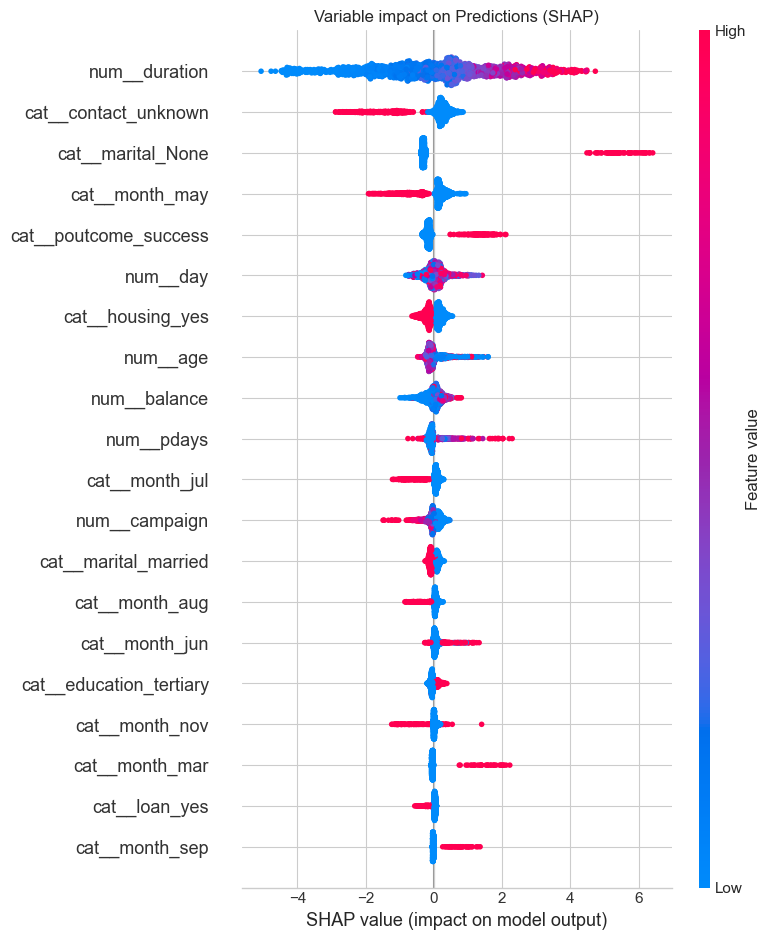

In [50]:
# We extract the model and the preprocessor
model_lgbm = lgbm_best.steps[-1][1] 
preprocessor = lgbm_best[:-1] 

# We transform the test
X_test_transformed = preprocessor.transform(X_test)

# ensure correct format for SHAP
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = [f"Feature {i}" for i in range(X_test_transformed.shape[1])]

X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# We define the SHAP explainer
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer.shap_values(X_test_transformed_df)

# We extract the SHAP values for the positive class ("yes")
if isinstance(shap_values, list):
    shap_values = shap_values[1]

plt.title("Variable impact on Predictions (SHAP)")
shap.summary_plot(shap_values, X_test_transformed_df, show=False)
plt.show()

In [51]:
# Muestra el conteo de cada valor, incluyendo los NaN
print(data['marital'].value_counts(dropna=False))

marital
married     5969
single      3281
divorced    1212
None         538
Name: count, dtype: int64


In [52]:
# Muestra el conteo de cada valor, incluyendo los NaN
print(data['marital'].unique())

['married' 'single' 'divorced' None]


#### Conclusions from SHAP Analysis

The SHAP analysis provides a transparent and reliable interpretation of how individual features influence the predicted probability of subscribing to a term deposit. The following key insights emerge from the summary plot.

**Dominant Effect of Contact Duration**  
The duration of the last contact is the most influential variable by a wide margin. Longer interactions strongly increase the predicted probability of subscription, while very short calls push predictions decisively toward non-subscription. This highlights the importance of client engagement quality during the interaction.

**Impact of Communication Uncertainty**  
Observations where the contact type is unknown show a strong negative contribution to the model output. This suggests that incomplete or unclear communication channels are associated with unsuccessful outcomes, potentially reflecting lower engagement or poor-quality interactions.

**Role of Previous Campaign Outcomes**  
A successful outcome in a previous marketing campaign has a strong positive impact on the prediction. Clients who subscribed in earlier campaigns behave as warm leads and are significantly more likely to subscribe again, underlining the predictive value of historical campaign information.

**Seasonality Effects**  
The month of the last contact introduces clear seasonal patterns. Contacts made in May tend to decrease the probability of subscription, whereas months such as March, September, and October contribute positively. This indicates that client responsiveness varies across the year and that campaign timing can be strategically optimized.

**Financial Situation and Existing Liabilities**  
Clients with existing housing or personal loans generally receive negative contributions to the predicted probability, suggesting lower willingness or capacity to invest in a term deposit. In contrast, higher average account balances slightly increase the probability of subscription, reflecting greater financial flexibility.

**Evidence of Campaign Fatigue**  
An increasing number of contacts within the same campaign negatively affects the prediction. This pattern suggests diminishing returns from repeated outreach and indicates that excessive contact may reduce the likelihood of success. The most effective interactions tend to occur within the first few contacts.

###  <span style="color:#0066CC"> Lime </span>

In [34]:
cat_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]
transformers = {} 
categorical_names = {}
X_train_lime = X_train.copy()

for col in cat_columns:
    le = LabelEncoder()
    le.fit(X_train[col])
    X_train_lime[col] = le.transform(X_train[col])
    
    transformers[col] = le
    categorical_names[X_train.columns.get_loc(col)] = le.classes_

data_lime = X_train_lime.values.astype(float)

def predict_fn_lime(data_numpy):

    df_temp = pd.DataFrame(data_numpy, columns=X_train.columns)

    for col in cat_columns:

        df_temp[col] = transformers[col].inverse_transform(df_temp[col].astype(int))

    return lgbm_best.predict_proba(df_temp)

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=data_lime,
    feature_names=X_train.columns.tolist(),
    categorical_features=cat_indices,
    categorical_names=categorical_names, 
    class_names=['No', 'Yes'], 
    mode='classification'
)

idx = 15
instancia_texto = X_test.iloc[idx]
instancia_lime = instancia_texto.copy()

for col in cat_columns:
    instancia_lime[col] = transformers[col].transform([instancia_texto[col]])[0]

instancia_lime_np = instancia_lime.values.astype(float)

print("Generating LIME explanation...")
exp = explainer_lime.explain_instance(
    data_row=instancia_lime_np,
    predict_fn=predict_fn_lime, 
    num_features=10
)

html_data = exp.as_html(show_table=True)


# Save the explanation to a file named 'lime_explanation.html'
exp.save_to_file('lime_explanation.html')

print("✅ HTML file saved successfully as 'lime_explanation.html'")


Generating LIME explanation...
✅ HTML file saved successfully as 'lime_explanation.html'


#### LIME Analysis: Test Individual Number 15

**Prediction:** **NO** (Probability: 1.00)

This specific case illustrates a "textbook rejection" where the model is 100% confident that the client will not subscribe. LIME highlights the following key factors driving this decision:

* **Critical Negative Drivers (Blue Bars):**
    * **Short Duration (135s):** The strongest indicator of failure. A call lasting barely over 2 minutes is insufficient to close a term deposit, signaling disinterest or a quick hang-up.
    * **Seasonality (Month = May):** The contact occurred in May, which the global model (SHAP) previously identified as the worst-performing month for conversions.
    * **Unknown Contact Method:** The lack of a specific contact type (cellular/telephone) is heavily penalized by the model, often correlating with lower quality leads.
    * **Housing Loan:** The client has an existing mortgage (`housing=yes`), suggesting financial constraints that reduce the likelihood of opening a new deposit.

* **Minor Positive Factors (Orange Bars):**
    * **No Personal Loan & Low Fatigue:** Although the client has no personal loan (`loan=no`) and this was the first call (`campaign=1`), these positive signals were completely overwhelmed by the short duration and poor timing.

#### Consistency Check: LIME (Local) vs. SHAP (Global)

By comparing the LIME explanation for **Test Individual #15** against the global SHAP summary, we can confirm that the model's behavior is consistent and logical. The reasons for rejecting this client align perfectly with the general patterns learned by the model.

| Feature | Value for Client #15 | Local Effect (LIME) | Global Rule (SHAP) | Consistency |
| :--- | :--- | :--- | :--- | :--- |
| **Duration** | `135` (Short) | **Negative (Blue)** <br> *Primary driver for rejection.* | **Negative** <br> Short calls (blue dots) are the strongest predictor of failure. | ✅ **Match** |
| **Month** | `May` | **Negative (Blue)** | **Negative** <br> `month_may` is clearly associated with negative outcomes (red dots on the left). | ✅ **Match** |
| **Contact** | `Unknown` | **Negative (Blue)** | **Negative** <br> `contact_unknown` strongly pushes predictions to the negative side. | ✅ **Match** |
| **Housing Loan** | `Yes` | **Negative (Blue)** | **Negative** <br> Clients with housing loans (`housing_yes`) are generally less likely to subscribe. | ✅ **Match** |
| **Personal Loan** | `No` | **Positive (Orange)** <br> *Small boost.* | **Positive** <br> Since `loan_yes` is a negative factor, being debt-free (`loan_no`) is a positive signal. | ✅ **Match** |

#### Conclusion
The prediction for Client #15 is **not an anomaly**. The model rejected this client because they exhibited a combination of the strongest negative traits identified globally: a short interaction time, during a historically poor month (May), with no verified contact channel.

###  <span style="color:#0066CC"> Feature Importance </span>

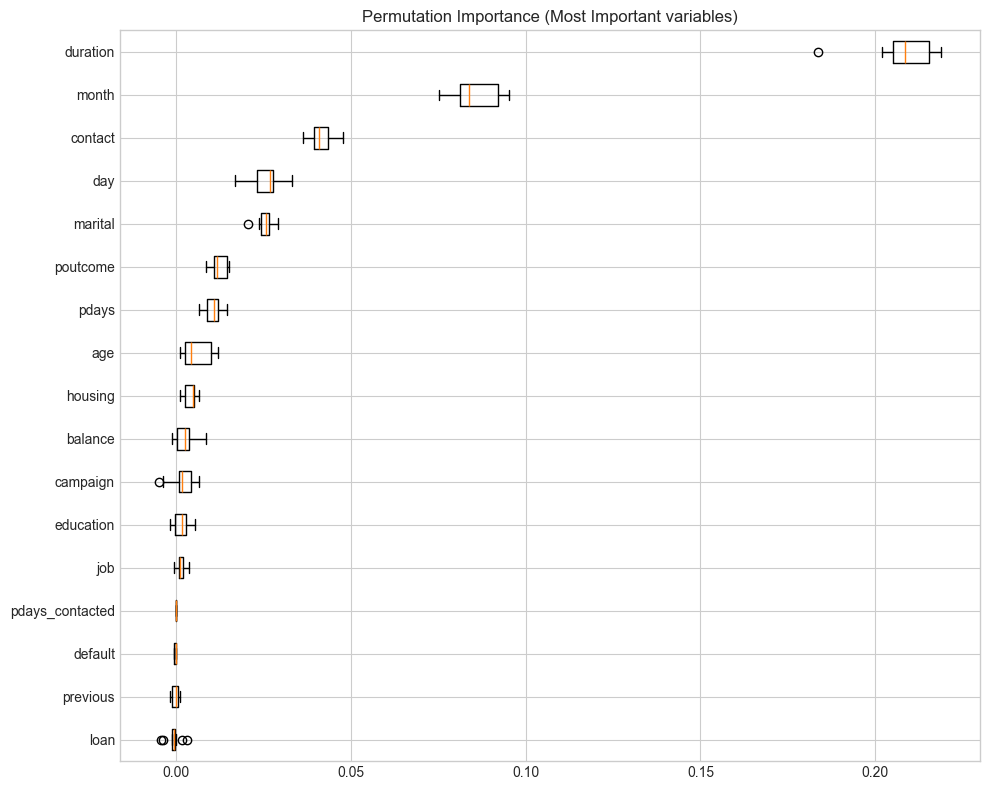

In [ ]:
perm_importance = permutation_importance(
    lgbm_best, X_test, y_test, n_repeats=10, random_state=100473854, n_jobs=-1
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(
    perm_importance.importances[sorted_idx].T,
    vert=False,
    labels=X_test.columns[sorted_idx]
)
plt.title("Permutation Importance (Most Important variables)")
plt.tight_layout()
plt.show()

The permutation variables analysis confirms the previous insights. The LightGBM classification model relies strongly on call-related and temporal variables to predict whether a client will subscribe to a term deposit. While the model achieves strong predictive performance, careful consideration of feature availability and potential data leakage is essential to ensure valid and actionable results.






